In [5]:
import os
import sys
# import itertools
# import dill

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from importlib import reload
# import scipy.special
import scipy.signal
# import scipy.optimize
# import scipy.linalg
# import scipy.stats

import figure_plotting_methods as fpm

reload(fpm)


%matplotlib inline

font = {'family' : 'serif',
        'size'   : 16}
text = {'usetex' : True}

plt.rc('font', **font)
plt.rc('text',**text)
plt.rc('axes', titlesize=18)

# Antisymmetric Trajectories

Good figures from:
* K = 301, T = 50, seed1 = 1, seed2 = 8, seed3 = 4

### Run antisymmetric simulation

In [136]:
## Find fixed pt species

K = 301 #choose odd number of species
seed1 = 1

AD = fpm.AntisymDynamics(K,seed=seed1)
AD.RunAntisymDynamics()
AD.FindAntisymFixedPt()
n_fp = K*AD.n_fp # vector(K,) with fixed pt abundances

fp_index = n_fp > 0
n_fp = n_fp[fp_index]
A = AD.A[fp_index,:][:,fp_index]/np.sqrt(K)  #interaction matrix
K_fp = np.sum(fp_index) #number of fixed pt species

 Saturated fixed pt found in 7 loops


In [137]:
## Generate initial log-abundances (x0) with set temperature T

T = 50  #50
seed2 = 8  #8
np.random.seed(seed2)
x0 = fpm.antisym_generate_init_equilibrium(n_fp,T,K)

T1 = np.mean(-n_fp*x0)
print(T1)

41.603095414644095


In [138]:
# Add new types

# Generate interactions
new_type_num = 15  #15
seed3= 4  #4
np.random.seed(seed3)
A_new_old = np.random.randn(new_type_num,K_fp)/np.sqrt(K)

# Compute bias
biases = A_new_old @ n_fp

# Choose species with bias close to +1.
new_type_ind = np.argmin((biases-1)**2)
new_type_bias = biases[new_type_ind]
A_new_type = A_new_old[new_type_ind,:]

print(new_type_bias)

0.9037426162312147


In [139]:
# Run dynamics with and without new type

# Make new matrix of interactions
A_new = np.zeros((K_fp+1,K_fp+1))
A_new[:K_fp,:K_fp] = A
A_new[K_fp,:K_fp] = A_new_type
A_new[:K_fp,K_fp] = -A_new_type

## Initial abundances
x0_new = np.zeros((K_fp+1))
x0_new[K_fp] = np.log(1e-10*K)
x0_new[:K_fp] = x0
x0_new = x0_new + np.log(K)- np.log(np.sum(np.exp(x0_new)))

## Set timescales
dt = .1/np.sqrt(T)
total_time = 10*T

## Run dynamics
AD_old = fpm.AntisymDynamics(K_fp, A = A)
AD_old.RunAntisymDynamics(x0=x0,dt = dt,total_time=total_time)

AD_new = fpm.AntisymDynamics(K_fp+1,A = A_new)
AD_new.RunAntisymDynamics(x0=x0_new,dt = dt,total_time=total_time)

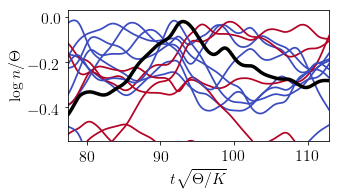

In [140]:
# Convert to natural norm
tvec1 = AD_old.tvec*np.sqrt(K)
tvec2 = AD_new.tvec*np.sqrt(K)

t0 = .24*T*np.sqrt(K)  #timepoints in long time units T sqrt(K)   #0.22
t1 = .35*T*np.sqrt(K) #0.44

# Convert to frequency norm
x_traj1 = AD_old.x_traj - np.log(K)
x_traj2 = AD_new.x_traj - np.log(K)

n_traj1 = np.exp(x_traj1)/K
n_traj2 = np.exp(x_traj2)/K

plt.figure(figsize=(5,3))

window = tvec2/(T*np.sqrt(K)) < 3
interaction = (A_new[:K_fp,K_fp]*np.sqrt(K))
# int_min = np.min(interaction)
# int_max = np.max(interaction)
# int_norm = (interaction-int_min)/(int_max-int_min)
int_norm = 0.5*np.ones((K_fp))
int_norm[interaction>1.5]=1
int_norm[interaction<1.5]=0

strong_indices = np.arange(K_fp)[np.abs(interaction)>1.5]

for ii in strong_indices:
    plt.plot(tvec2[window]*np.sqrt(T1/K),x_traj2[ii,window]/T1,color=plt.cm.coolwarm(int_norm[ii]),alpha=1,zorder=(int_norm[ii]-0.5)**2,linewidth=1.75)
    
plt.plot(tvec2[window]*np.sqrt(T1/K),x_traj2[K_fp,window]/T1,color='k',linewidth = 3.5)
plt.ylim((-.55,0.03))  
plt.xlim((t0*np.sqrt(T1/K),t1*np.sqrt(T1/K)))

plt.xlabel(r'$t \sqrt{\Theta/K}$')
plt.ylabel(r'$\log n / \Theta$')

plt.tight_layout()
#plt.savefig('figures/antisym_short_time.pdf')

# plt.colorbar()

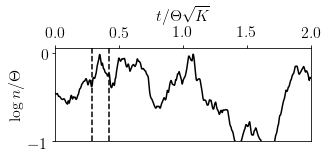

In [141]:
time_rescale = T1*np.sqrt(K)


fig= plt.figure(figsize=(5,2.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(tvec2/time_rescale,x_traj2[-1,:]/T,'k')

vec = np.arange(-1,.2,.01)
ax.plot(t0/time_rescale+0*vec,vec,'k--')
ax.plot(t1/time_rescale+0*vec,vec,'k--')


ax.set_xlim((0,2))
ax.set_ylim((-1,0.05))

ax.set_xlabel(r'$t/\Theta \sqrt{K}$')
ax.set_ylabel(r'$\log n / \Theta$')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.tight_layout()
#plt.savefig('figures/antisym_long_time.pdf')

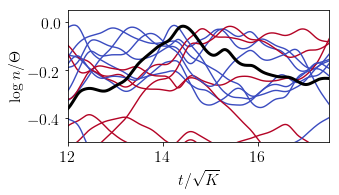

In [142]:
t0 = .22  #timepoints in units of T
t1 = .44


tvec1 = AD_old.tvec
tvec2 = AD_new.tvec

x_traj1 = AD_old.x_traj
x_traj2 = AD_new.x_traj

n_traj1 = np.exp(x_traj1)
n_traj2 = np.exp(x_traj2)

plt.figure(figsize=(5,3))

window = tvec2/T < 3
interaction = (A_new[:K_fp,K_fp]*np.sqrt(K))
# int_min = np.min(interaction)
# int_max = np.max(interaction)
# int_norm = (interaction-int_min)/(int_max-int_min)
int_norm = 0.5*np.ones((K_fp))
int_norm[interaction>1.5]=1
int_norm[interaction<1.5]=0

strong_indices = np.arange(K_fp)[np.abs(interaction)>1.5]

for ii in strong_indices:
    plt.plot(tvec2[window],(AD_new.x_traj[ii,window]-np.log(K))/T,color=plt.cm.coolwarm(int_norm[ii]),alpha=1,zorder=(int_norm[ii]-0.5)**2,linewidth=1.4)
    
plt.plot(tvec2[window],(AD_new.x_traj[K_fp,window]-np.log(K))/T,color='k',linewidth = 3)
plt.ylim((-.5,0.05))  
plt.xlim((t0*T**(3/2)*np.sqrt(1/T),t1*T**(3/2)*np.sqrt(1/T)))

plt.xlabel(r'$t/\sqrt{K}$')
plt.ylabel(r'$\log n / \Theta$')

plt.tight_layout()
# plt.savefig('antisym_short_time_naturalnorm.pdf')

# plt.colorbar()

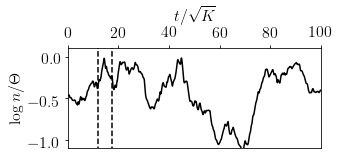

In [143]:
fig= plt.figure(figsize=(5,2.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(AD_new.tvec,(AD_new.x_traj[-1,:]-np.log(K))/T,'k')

factor = T

vec = np.arange(-1.5,.2,.01)
ax.plot(t0*factor+0*vec,vec,'k--')
ax.plot(t1*factor+0*vec,vec,'k--')


ax.set_xlim((0,2*factor))
ax.set_ylim((-1.1,.1))

ax.set_xlabel(r'$t/\sqrt{K}$')
ax.set_ylabel(r'$\log n / \Theta$')

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

plt.tight_layout()
#plt.savefig('figures/antisym_long_time_naturalnorm.pdf')

Figures for paper: $\theta = 50$, $K = 301$, $N = 1$

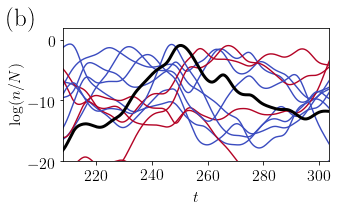

In [184]:
t0 = .24  #timepoints in units of T
t1 = .35


tvec1 = AD_old.tvec
tvec2 = AD_new.tvec*np.sqrt(K)

x_traj1 = AD_old.x_traj
x_traj2 = AD_new.x_traj

n_traj1 = np.exp(x_traj1)
n_traj2 = np.exp(x_traj2)

plt.figure(figsize=(5,3))

window = tvec2/T < 3*np.sqrt(K)
interaction = (A_new[:K_fp,K_fp]*np.sqrt(K))
# int_min = np.min(interaction)
# int_max = np.max(interaction)
# int_norm = (interaction-int_min)/(int_max-int_min)
int_norm = 0.5*np.ones((K_fp))
int_norm[interaction>1.5]=1
int_norm[interaction<1.5]=0

strong_indices = np.arange(K_fp)[np.abs(interaction)>1.5]

for ii in strong_indices:
    plt.plot(tvec2[window],(AD_new.x_traj[ii,window]-np.log(K)),color=plt.cm.coolwarm(int_norm[ii]),alpha=1,zorder=(int_norm[ii]-0.5)**2,linewidth=1.4)
    
plt.plot(tvec2[window],(AD_new.x_traj[K_fp,window]-np.log(K)),color='k',linewidth = 3)
plt.ylim((-20,2))  
plt.xlim((t0*T**(3/2)*np.sqrt(1/T)*np.sqrt(K),t1*T**(3/2)*np.sqrt(1/T)*np.sqrt(K)))

plt.xlabel(r'$t$')
plt.ylabel(r'$\log(n / N)$')

# label for paper
ax = plt.gca()
x_lab = -0.21
y_lab = 1.02
plt.text(x_lab,y_lab,'(b)',fontsize=25,weight='bold',transform=ax.transAxes)


plt.tight_layout()
plt.savefig('figures/antisym_short_time.pdf')

# plt.colorbar()

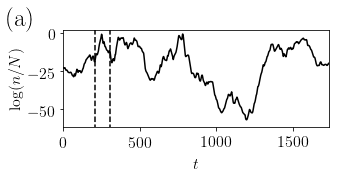

In [183]:
fig= plt.figure(figsize=(5,2.5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(AD_new.tvec*np.sqrt(K),(AD_new.x_traj[-1,:]-np.log(K)),'k')

factor = T

vec = np.arange(-64,5,1.)
ax.plot(np.sqrt(K)*(t0*factor+0*vec),vec,'k--')
ax.plot(np.sqrt(K)*(t1*factor+0*vec),vec,'k--')


ax.set_xlim((0,2*factor*np.sqrt(K)))
ax.set_ylim((-62,2))

ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$\log(n / N)$')

#ax.xaxis.tick_top()
#ax.xaxis.set_label_position('top')

# label for paper
x_lab = -0.21
y_lab = 1.05
plt.text(x_lab,y_lab,'(a)',fontsize=25,weight='bold',transform=ax.transAxes)

plt.tight_layout()
plt.savefig('figures/antisym_long_time.pdf')

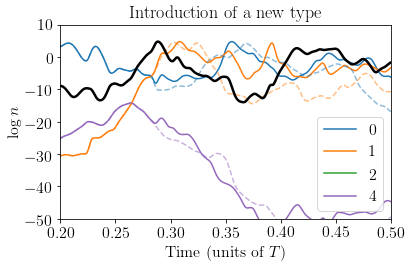

In [329]:
# Find types with large response

tvec1 = AD_old.tvec
tvec2 = AD_new.tvec

x_traj1 = AD_old.x_traj
x_traj2 = AD_new.x_traj

n_traj1 = np.exp(x_traj1)
n_traj2 = np.exp(x_traj2)

## Find time when species is large
window = tvec2/T < 1
n_new = n_traj2[K_fp,window]
n_large_ind = np.argmax(n_new)

## Find other types with large response. 
fitness_due_to_new = np.einsum('j,t->jt',A_new[:K_fp,K_fp],n_traj2[K_fp,:])
fitness_when_large = fitness_due_to_new[:,n_large_ind]
sort_ind = np.argsort(fitness_when_large)[::-1]


# Plot types with largest response
plot_indices = [0,1,2,4]

## plot new trajectories for selected types
time = 2

tvec3 = tvec2/T
window = tvec3 < time
for ind in plot_indices:
    type_ind = sort_ind[ind]
    plt.plot(tvec3[window],x_traj2[type_ind,window],color='C{}'.format(np.mod(ind,10)),label=ind)
    
## plot previous trajectories for same types
start_ind = 0
tvec_fp_prev = (tvec1[start_ind:] - tvec1[start_ind])/T
n_fp_traj_prev = n_traj1[:,start_ind:]

window2 = tvec_fp_prev < time

for ind in plot_indices:
    type_ind = sort_ind[ind]
    plt.plot(tvec_fp_prev[window2],np.log(n_fp_traj_prev[type_ind,window2]),'--',color='C{}'.format(np.mod(ind,10)),alpha=0.5)
    
plt.plot(tvec3[window],x_traj2[K_fp,window],'k',linewidth=2.5)
plt.ylim((-T,10))
plt.xlabel(r'Time (units of $T$)')
plt.ylabel(r'$\log n$')
plt.title('Introduction of a new type')
plt.legend()

plt.xlim((0.2,.5))

plt.tight_layout()

# plt.savefig('antisym_short_time_alternative.pdf')

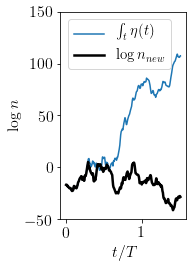

In [354]:
# Plot of integrated noise vs n_traj
time = 1.5*T
## Find integrated noise trajectory

start_ind = 0
tvec_fp_prev = (tvec1[start_ind:] - tvec1[start_ind])
window2 = tvec_fp_prev< time

dt = tvec_fp_prev[1] - tvec_fp_prev[0]
noise_new = A_new[K_fp,:K_fp] @ n_traj1[:K_fp,:]
integrated_noise_new = np.log(n_traj2[K_fp,0])+dt*np.cumsum(noise_new)

# window = tvec3 < time

plt.figure(figsize = (3,4))
plt.plot(tvec_fp_prev[window2]/T,integrated_noise_new[window2],label='$\int_t \eta(t)$')
plt.plot(tvec2[window2]/T,np.log(n_traj2[K_fp,window2]),'k',linewidth=2.5,label='$\log n_{new}$')

plt.ylim((-50,150))
plt.xlabel(r'$t/T$')
plt.ylabel(r'$\log n$')
# plt.title('Introduction of a new type')
plt.legend(prop={'size':15})

plt.tight_layout()
# plt.savefig('antisym_integrated_noise.pdf')

# Antisymmetric fixed points

## Fraction surviving with fitness differences

In [68]:
data_saved = os.path.isfile('fixed_pt_with_s.npz')

In [69]:
if not data_saved:

    # run simulations if data not saved


    def gen_int_mat(K,sig_s):
        # generate interactions for antisymmetric + Gaussian fitness differences
        A = np.random.randn(K,K)
        A = (A-A.T)/np.sqrt(2)
        s_i = sig_s*np.random.randn(K,1)
        A = A+s_i@np.ones((1,K))-np.ones((K,1))@s_i.T

        return A


    n_samples = 20
    Ks = np.array([100,200,400,800,1600,3200])
    #sig_ss = [0.03,0.1,0.3]
    sig_ss = [0.04,0.08,0.16,0.32]

    #Ks = [1600]
    #sig_ss = [0.3]

    frac_surv = np.zeros((len(Ks),len(sig_ss),n_samples))

    for i,K in enumerate(Ks):
        for j,sig_s in enumerate(sig_ss):
            print('K: {}, \sigma_s: {}'.format(K,sig_s))
            for k in range(n_samples):
                A = gen_int_mat(K,sig_s)
                n_star = fpm.find_fixed_pt(A)
                frac_surv[i,j,k] = fpm.count_alive(n_star)*1.0/K



    frac_surv_ave = np.mean(frac_surv,axis=2)

    # save data

    data_dict = {'Ks':Ks,'sig_ss':sig_ss,'n_samples':n_samples,'frac_surv_ave':frac_surv_ave,'frac_surv':frac_surv}
    np.savez('fixed_pt_with_s',data_dict)

In [38]:
with np.load('fixed_pt_with_s.npz') as load_data:
    data_dict = load_data['arr_0'].item()
    
Ks = data_dict['Ks']
sig_ss = data_dict['sig_ss']
frac_surv_ave = data_dict['frac_surv_ave']

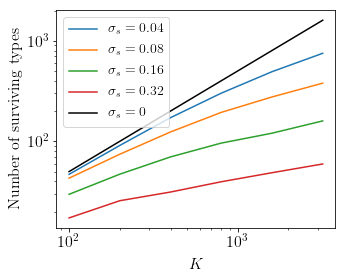

In [64]:
plt.figure(figsize=(5,4))
for i,sig_s in enumerate(sig_ss):
    K_eff = np.array(Ks)*(sig_s**2)
    
    plt.plot(Ks,(1.0*Ks)*frac_surv_ave[:,i],label=r'$\sigma_s = {:.2f}$'.format(sig_s))
    #plt.plot(Ks,2*np.log(K_eff)/K_eff,color="C{}".format(i),ls='--')
plt.plot(Ks,Ks/2.,color='k',label='$\sigma_{s} = 0$')
plt.legend(loc='upper left',fontsize=14)
plt.xlabel(r'$K$')
plt.ylabel('Number of surviving types')
plt.yscale('log')
plt.xscale('log')
plt.savefig('figures/fit_diff_surviving.pdf',transparent=True)

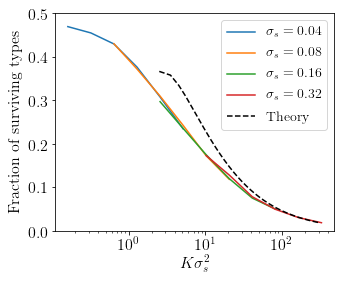

In [65]:
plt.figure(figsize=(5,4))
for i,sig_s in enumerate(sig_ss):
    K_eff = np.array(Ks)*(sig_s**2)
    
    plt.plot(K_eff,frac_surv_ave[:,i],label=r'$\sigma_s = {:.2f}$'.format(sig_s))
K_eff_theory = np.arange(2.5,300,1)
plt.plot(K_eff_theory,np.log(K_eff_theory)/K_eff_theory,color='k',ls='--',label='Theory')
plt.legend(loc='upper right',fontsize=14)
plt.ylim((0,0.5))
plt.xlabel(r'$K\sigma_{s}^{2}$')
plt.ylabel('Fraction of surviving types')
plt.xscale('log')
plt.savefig('figures/fit_diff_rescaled.pdf',transparent=True)

# Near Antisymmetric Unstable

## Average lambda and temperature change

In [1316]:
# Function to find lambda and temperature as function of time.

def nearAntisymRun(K,gamma,seed,time = 4,fixedPtOnly=True):
    if K % 2 == 0:
        K = K+1

    # find fixed pt types
    AD = fpm.AntisymDynamics(K,seed=seed)
    AD.RunAntisymDynamics()
    AD.FindAntisymFixedPt()
    
    n_fp = np.reshape(K*AD.n_fp,(K,1)) # vector(K,1) with fixed pt abundances
    fp_index = AD.fp_index

    # run near antisym dynamics
    M = np.inf
    AD.ChangeInteractions(gamma)
    AD.RunNearAntisymDynamics(M,time,fixedPtOnly=fixedPtOnly)
    
    tvec = AD.tvec*np.sqrt(K)
    x_traj = AD.x_traj + np.log(K)
    n_traj = np.exp(x_traj)
    
    V = AD.V/np.sqrt(K)
    lambd = np.einsum('it,ij,jt->t',n_traj,V,n_traj)/K
    temp = -np.mean(n_fp[fp_index,:] * np.log(n_traj[fp_index,:]/n_fp[fp_index,:]),axis=0)
    
    return tvec, lambd, temp, x_traj, V, AD.A

In [1317]:
data = np.load('nearAntisym_plotdata.npz')
temp_array = data['temp_array']
lambd_array = data['lambd_array']
tvec = data['tvec']
K = 301
g = -0.99

index = np.logical_not(np.all(lambd_array==0,axis=1))
lambd_array = lambd_array[index]
temp_array = temp_array[index]
tvec = tvec/K
rep_num = np.shape(lambd_array)[0]

# average over some time bin
dt = 0.1*K
bin_num = int(tvec[-1]//dt)
lambd_ave = np.zeros((bin_num))
lambd_err = np.zeros((bin_num))
temp_ave = np.zeros((bin_num))
temp_err = np.zeros((bin_num))
tvec_ave = np.zeros((bin_num))

for bin_ind in range(bin_num):
    t0 = bin_ind*dt
    t1 = (bin_ind+1)*dt
    window = np.logical_and(tvec>=t0,tvec<t1)
    lambd_ave[bin_ind] = np.mean(lambd_array[:,window]) 
    lambd_err[bin_ind] = np.std(lambd_array[:,window])/np.sqrt(rep_num)
    temp_ave[bin_ind] = np.mean(temp_array[:,window]) 
    temp_err[bin_ind] = np.std(temp_array[:,window])/np.sqrt(rep_num)
    tvec_ave[bin_ind] = np.mean(tvec[window])

/Users/michaelpearce/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


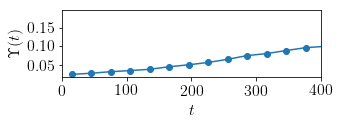

In [1329]:
### In Paper

plt.figure(figsize=(5,2))
plt.plot(tvec_ave,lambd_ave,'o-')
plt.xlabel(r'$t$')
plt.ylabel(r'$\Upsilon(t)$')

plt.xlim((0,400))
plt.tight_layout()

# plt.savefig('near_antisym_lambda.pdf')

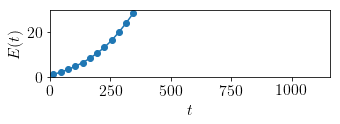

In [1331]:
plt.figure(figsize=(5,2))
plt.plot(tvec_ave,temp_ave,'o-')
plt.xlim((0,tvec_ave[-1]))
plt.xlabel(r'$t$')
plt.ylabel(r'$E(t)$')

# plt.xlim((0,400))
plt.tight_layout()


plt.savefig('near_antisym_temp.pdf')

## Timescale changing (not in paper)

In [439]:
K = 301
gamma = -0.99
seed = 1

tvec, lambd, temp, x_traj = nearAntisymRun(K,gamma,seed,4,False)
tvec = tvec/K

 Saturated fixed pt found in 7 loops


/Users/michaelpearce/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log


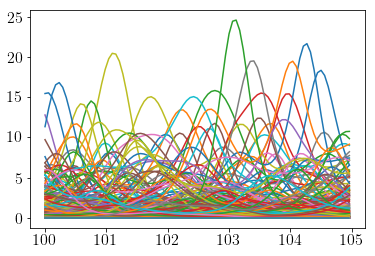

In [259]:
t0 = 100
dt = 5
window = np.logical_and(tvec>=t0,tvec<t0+dt)

fp_index= np.any(x_traj!=-np.inf,axis=1)
K_fp = np.sum(fp_index)
fp_indices = np.arange(K)[fp_index]

for ind in fp_indices[:]:
    plt.plot(tvec[window],np.exp(x_traj[ind,window]))
    
# plt.ylim((-10,10))

(-10, 10)

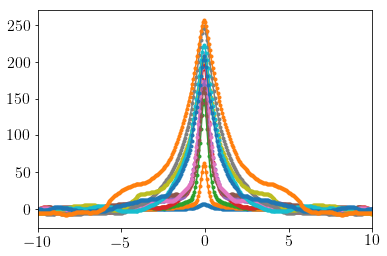

In [266]:
dt = 100
tend = dt*(tvec[-1]//dt)
for t0 in range(0,int(tend),dt):
    t1 = t0+dt
    window = np.logical_and(tvec>=t0,tvec<t1)
    
    n_traj = np.exp(x_traj[:,window])

    rows, cols = np.shape(n_traj)
    # autocorr_list = np.zeros((rows,cols))
    autocorr_sum = np.zeros((cols))
    nonzero_num = 0

    for ii in range(rows):
        n = n_traj[ii,:]  #convert to conventional normalization
        length = len(n)
        timepoint_num_vec = length - np.abs(np.arange(-length//2,length//2))  #number of time points used to evaluate autocorrelation
        autocorr = scipy.signal.fftconvolve(n,n[::-1],mode='same')/timepoint_num_vec
        autocorr_sum = autocorr_sum+autocorr
        nonzero_num = nonzero_num+1
        # autocorr_list[step,:] = autocorr
        
    n2 = np.mean(np.mean(n_traj,axis=1)**2)

    corr_tvec = (tvec[1]-tvec[0])*np.arange(-length//2,length//2)
    autocorr = autocorr_sum/K - n2
    autocorr2 = autocorr/np.max(autocorr)
    
    plt.plot(corr_tvec,autocorr,'.-')
    
plt.xlim((-10,10))

# plt.yscale('log')
# plt.ylim((1e-3,2))

## Comparison w antisymmetric

In [1332]:
K = 301
seed = 1
gamma = -0.99
fixedPtOnly=True
time = 4


# find fixed pt types
AD = fpm.AntisymDynamics(K,seed=seed)
AD.RunAntisymDynamics()
AD.FindAntisymFixedPt()

n_fp = np.reshape(K*AD.n_fp,(K,1)) # vector(K,1) with fixed pt abundances
fp_index = AD.fp_index

# run near antisym dynamics
M = np.inf
AD.ChangeInteractions(gamma)
AD.RunNearAntisymDynamics(M,time,fixedPtOnly=fixedPtOnly)

tvec = AD.tvec/np.sqrt(K)
x_traj = AD.x_traj + np.log(K)
n_traj = np.exp(x_traj)

V = AD.V/np.sqrt(K)
lambd = np.einsum('it,ij,jt->t',n_traj,V,n_traj)/K
temp = -np.mean(n_fp[fp_index,:] * np.log(n_traj[fp_index,:]/n_fp[fp_index,:]),axis=0)

    

 Saturated fixed pt found in 7 loops


/Users/michaelpearce/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log


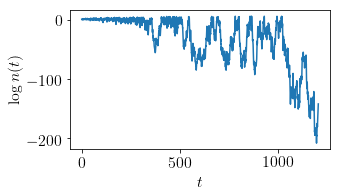

In [1334]:
plt.figure(figsize=(5,3))
plt.plot(tvec,x_traj[7,:])
plt.xlabel(r'$t$')
plt.ylabel(r'$\log n(t)$')

plt.tight_layout()
plt.savefig('near_antisym_x.pdf')

In [513]:
t = 300
t_ind = np.argmin((tvec-t)**2)
x0 = AD.x_traj[:,t_ind]

AD2 = fpm.AntisymDynamics(K,seed=seed,A = AD.A)
AD2.RunAntisymDynamics(x0=x0,dt = 0.1,total_time=2*K**(3/2),sample_time=1)

In [514]:
tvec2 = AD2.tvec/np.sqrt(K)
x_traj2 = AD2.x_traj+np.log(K)

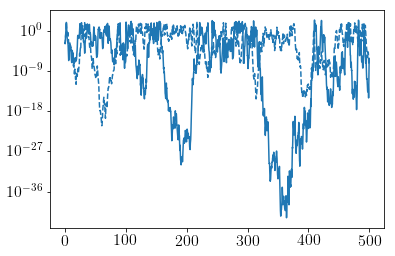

In [517]:
# ind = 3

time = 500
dt = tvec[1]-tvec[0]
steps = int(time/dt)

for ind in [10]:
    plt.plot(tvec[t_ind:t_ind+steps]-tvec[t_ind],np.exp(x_traj[ind,t_ind:t_ind+steps]),color='C{}'.format(np.mod(ind,10)))
    plt.plot(tvec2[:steps],np.exp(x_traj2[ind,:steps]),'--',color='C{}'.format(np.mod(ind,10)))
    
plt.yscale('log')


In [457]:
np.mod(34,10)

4

In [390]:
data = np.load('nearAntisym_plotdata.npz')
temp_array = data['temp_array']
lambd_array = data['lambd_array']
tvec = data['tvec']

In [394]:
index = np.logical_not(np.all(lambd_array==0,axis=1))
lambd_array = lambd_array[index]
temp_array = temp_array[index]

(86, 20889)

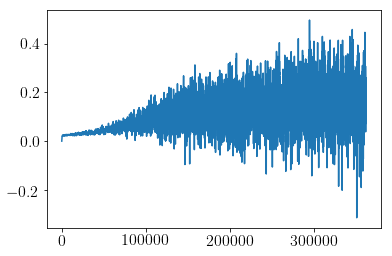

In [395]:
plt.plot(tvec,np.mean(lambd_array,axis=0))

# Estimating Bias
Estimate bias two ways: 
1. Use fact that $V<n> = \xi + \gamma \chi <n>$. Can estimate $\chi$ by averaging, $E[V<n>] = 0 + \gamma \chi$. Then use $\chi$ to estimate $\xi$.
2. Use the rank of $<n>$ and the variance of $\xi$ from $E[<n>^2]$ to estimate $\xi$.

## Data with $\gamma = -0.8$

* M = 20
* gamma = -0.8
* K = 100, D = [3 5 8 12 16 24 40 100]
* K = 500, D = 24
* replicates = 10

In [1210]:
data1 = np.load('theoryComp1_data.npz')
print(list(data1.keys()))
print(data1['D_list'])

data2 = np.load('theoryComp2_data.npz')

data3 = np.load('theoryComp3_data.npz')

['V_array', 'n_mean_array', 'n2_mean_array', 'n_std_array', 'M', 'K', 'gamma', 'logN', 'D_list', 'rep_num', 'lambda_mean_array', 'lambda_std_array']
[  3   5   8  12  16  24  40 100]


In [1176]:
np.mean(data1['lambda_mean_array'][5]/np.sqrt(data1['K']))

0.18520073791839015

In [1174]:
np.mean(data2['lambda_mean_array'][5]/np.sqrt(data2['K']))

0.13699884298794734

In [1178]:
np.mean(data3['lambda_mean_array'][5]/np.sqrt(data3['K']))

0.14329687136923078

In [965]:
#Compute growth rates for data1

D_ind = 5
rep_num = data1['rep_num']
K = data1['K']
gamma = data1['gamma']

n_mean_array1 = data1['n_mean_array'][D_ind]
n_std_array1 = data1['n_std_array'][D_ind]
lambda_array1 = np.reshape(data1['lambda_mean_array'][D_ind],(rep_num,1))

growth_rate_array1 = np.zeros((rep_num,K))

chi_vec1 = np.zeros((rep_num))

for rep_ind in range(rep_num):
    V = data1['V_array'][rep_ind]/np.sqrt(K)   #use meanfield norm for calculations
    n_mean = n_mean_array1[rep_ind]  #in meanfield norm
    n_std = n_std_array1[rep_ind]

    growth_rates = V @ n_mean
    growth_rate_array1[rep_ind,:] = growth_rates
    
    # estimate chi from E[V<n>]
    chi_vec1[rep_ind] = np.mean(growth_rates)/gamma

chi_vec1

array([0.57433555, 0.52999843, 0.63870095, 0.70405059, 0.75391922,
       0.98259112, 0.9009717 , 0.52469973, 0.58551978, 0.66745672])

In [1179]:
#Compute growth rates for data2

D_ind = 5
rep_num = data2['rep_num']
K = data2['K']
gamma = data2['gamma']

n_mean_array2 = data2['n_mean_array'][D_ind]
n_std_array2 = data2['n_std_array'][D_ind]
lambda_array2 = np.reshape(data2['lambda_mean_array'][D_ind],(rep_num,1))

growth_rate_array2 = np.zeros((rep_num,K))

chi_vec2 = np.zeros((rep_num))

for rep_ind in range(rep_num):
    V = data2['V_array'][rep_ind]/np.sqrt(K)   #use meanfield norm for calculations
    n_mean = n_mean_array2[rep_ind]  #in meanfield norm
    n_std = n_std_array2[rep_ind]

    growth_rates = V @ n_mean
    growth_rate_array2[rep_ind,:] = growth_rates
    
    # estimate chi from E[V<n>]
    chi_vec2[rep_ind] = np.mean(growth_rates)/gamma

chi_vec2

array([0.61851159, 0.68886779, 0.69098056, 0.56159609, 0.66995855,
       0.72410169, 0.78178728, 0.64503582, 0.68723177, 0.71584386])

In [966]:
#Compute growth rates for data3

D_ind = 5
rep_num = data3['rep_num']
K = data3['K']
gamma = data3['gamma']

n_mean_array3 = data3['n_mean_array'][D_ind]
n_std_array3 = data3['n_std_array'][D_ind]
lambda_array3 = np.reshape(data3['lambda_mean_array'][D_ind],(rep_num,1))

growth_rate_array3 = np.zeros((rep_num,K))

chi_vec3 = np.zeros((rep_num))

for rep_ind in range(rep_num):
    V = data3['V_array'][rep_ind]/np.sqrt(K)   #use meanfield norm for calculations
    n_mean = n_mean_array3[rep_ind]  #in meanfield norm
    n_std = n_std_array3[rep_ind]

    growth_rates = V @ n_mean
    growth_rate_array3[rep_ind,:] = growth_rates
    
    # estimate chi from E[V<n>]
    chi_vec3[rep_ind] = np.mean(growth_rates)/gamma

chi_vec3

array([0.65610872, 0.56670492, 0.63135292, 0.67278968, 0.66969126,
       0.62768766, 0.67744189, 0.70432791, 0.61883362, 0.71016979])

In [1180]:
print(lambda_array1)
print(lambda_array3)
print(np.mean(lambda_array1))

[[1.80558419]
 [1.88140485]
 [1.57832034]
 [2.0137217 ]
 [1.54175709]
 [1.78048686]
 [1.42041953]
 [2.55597019]
 [2.29558281]
 [1.64682623]]
[[2.62810558]
 [3.75065557]
 [2.93220214]
 [3.00502437]
 [3.46251693]
 [3.28309801]
 [3.05925316]
 [3.50270075]
 [3.7199331 ]
 [2.69866492]]
1.8520073791839013


-0.0014927331977488967
-0.004259368456354856
-0.018843720510427167


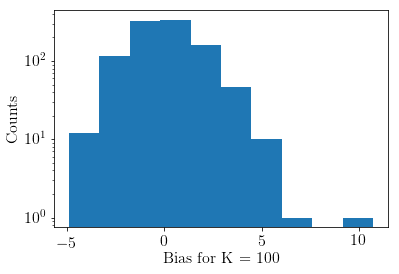

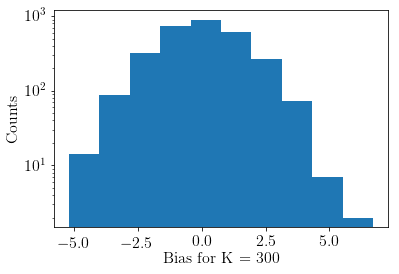

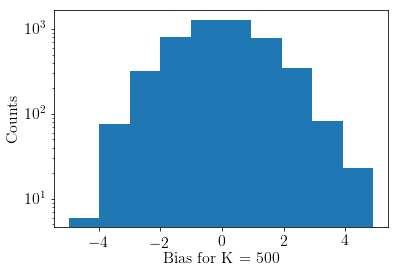

In [1186]:
# Choose chi that gives zero median for biases. Use all replicates for ensemble.
chi1 = .81
chi2 = .74
chi3 = .65

bias_array1 = growth_rate_array1 - gamma*chi1*n_mean_array1
bias1 = bias_array1.flatten()

print(np.median(bias1))
# print(scipy.stats.skew(bias1))
plt.hist(bias1)
plt.ylabel('Counts')
plt.xlabel('Bias for K = 100')
plt.yscale('log')

bias_array2 = growth_rate_array2 - gamma*chi2*n_mean_array2
bias2 = bias_array2.flatten()

plt.figure()
print(np.median(bias2))
# print(scipy.stats.skew(bias1))
plt.hist(bias2)
plt.ylabel('Counts')
plt.xlabel('Bias for K = 300')
plt.yscale('log')

bias_array3 = growth_rate_array3 - gamma*chi3*n_mean_array3
bias3 = bias_array3.flatten()

plt.figure()
print(np.median(bias3))
# print(scipy.stats.skew(bias3))
plt.hist(bias3)
plt.ylabel('Counts')
plt.xlabel('Bias for K = 500')
plt.yscale('log')

# plt.figure()
# plt.plot(bias-lambdas.flatten(),n_means,'.')
# plt.yscale('log')
# plt.ylim((1e-4,20))

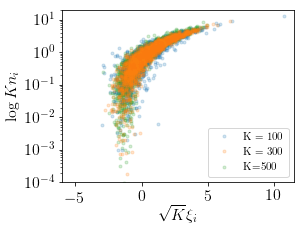

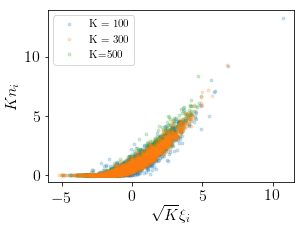

In [1214]:

plt.figure(figsize=(4.5,3.5))
plt.plot(bias_array1.flatten(),n_mean_array1.flatten(),'.',alpha=0.2,label='K = 100')
plt.plot(bias_array2.flatten(),n_mean_array2.flatten(),'.',alpha=0.2,label='K = 300')
plt.plot(bias_array3.flatten(),n_mean_array3.flatten(),'.',zorder=-1,alpha=0.2,label='K=500')

plt.yscale('log')
plt.ylim((1e-4,20))
# plt.xlim((-7,7))

plt.ylabel(r'$\log K n_i$')
plt.xlabel(r'$\sqrt{K}\xi_i$')
plt.legend(prop={'size':11})


plt.tight_layout()
plt.savefig('bias_estimate_g08_nolambda_log.pdf')

plt.figure(figsize=(4.5,3.5))
plt.plot(bias_array1.flatten(),n_mean_array1.flatten(),'.',alpha=0.2,label='K = 100')
plt.plot(bias_array2.flatten(),n_mean_array2.flatten(),'.',alpha=0.2,label='K = 300')
plt.plot(bias_array3.flatten(),n_mean_array3.flatten(),'.',zorder=-1,alpha=0.2,label='K=500')

# plt.yscale('log')
# plt.ylim((1e-4,20))
# plt.xlim((-7,7))

plt.ylabel(r'$K n_i$')
plt.xlabel(r'$\sqrt{K}\xi_i$')
plt.legend(prop={'size':11})

plt.tight_layout()
plt.savefig('bias_estimate_g08_nolambda_linear.pdf')

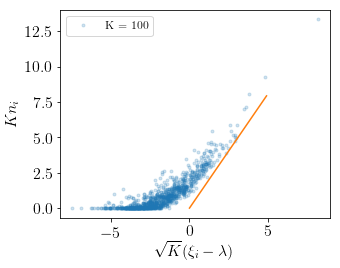

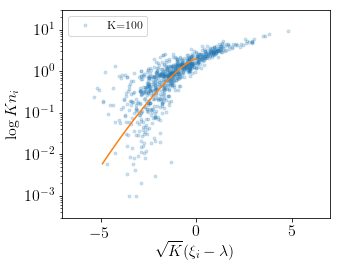

In [1217]:
bias_with_lambda1 = bias_array1 - lambda_array1

plt.figure(figsize=(5,4))
plt.plot(bias_with_lambda1.flatten(),n_mean_array1.flatten(),'.',zorder=-1,alpha=0.2,label='K = 100')

xvec = np.arange(0,5,.1)
plt.plot(xvec,-xvec/(gamma*chi3))

# plt.yscale('log')
# plt.ylim((1e-4,10))
# plt.xlim((-7,7))

plt.ylabel(r'$K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \lambda)$')
plt.legend(prop={'size':12})

plt.tight_layout()

plt.figure(figsize=(5,4))
plt.plot(bias_with_lambda1.flatten(),n_mean_array1.flatten(),'.',zorder=-1,alpha=0.2,label='K=100')

xvec = np.arange(0,5,.1)
plt.plot(-xvec, 2*np.exp(-0.7*xvec**(4/3)))

plt.yscale('log')
plt.ylim((3e-4,30))
plt.xlim((-7,7))

plt.ylabel(r'$\log K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \lambda)$')
plt.legend(prop={'size':12})

plt.tight_layout()

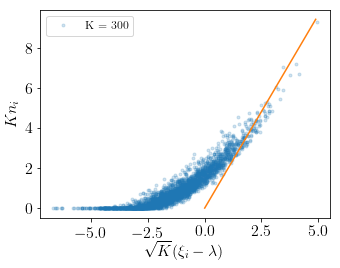

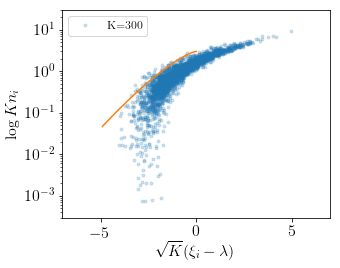

In [1197]:
bias_with_lambda2 = bias_array2 - lambda_array2/np.sqrt(3)

plt.figure(figsize=(5,4))
plt.plot(bias_with_lambda2.flatten(),n_mean_array2.flatten(),'.',zorder=-1,alpha=0.2,label='K = 300')

xvec = np.arange(0,5,.1)
plt.plot(xvec,-xvec/(gamma*chi3))

# plt.yscale('log')
# plt.ylim((1e-4,10))
# plt.xlim((-7,7))

plt.ylabel(r'$K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \lambda)$')
plt.legend(prop={'size':12})

plt.tight_layout()

plt.figure(figsize=(5,4))
plt.plot(bias_with_lambda2.flatten(),n_mean_array2.flatten(),'.',zorder=-1,alpha=0.2,label='K=300')

xvec = np.arange(0,5,.1)
plt.plot(-xvec, 3*np.exp(-0.5*xvec**(4/3)))

plt.yscale('log')
plt.ylim((3e-4,30))
plt.xlim((-7,7))

plt.ylabel(r'$\log K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \lambda)$')
plt.legend(prop={'size':12})

plt.tight_layout()

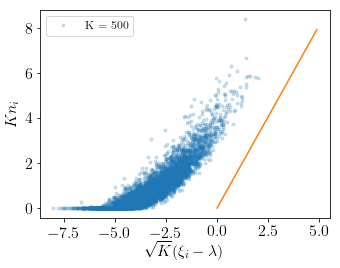

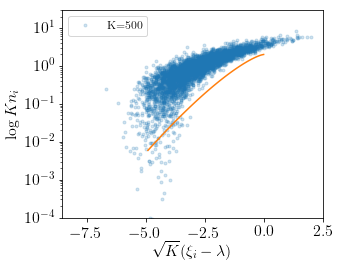

In [1216]:
bias_with_lambda3 = bias_array3 - lambda_array3

plt.figure(figsize=(5,4))
plt.plot(bias_with_lambda3.flatten(),n_mean_array3.flatten(),'.',zorder=-1,alpha=0.2,label='K = 500')

xvec = np.arange(0,5,.1)
plt.plot(xvec,-xvec/(gamma*chi3))

# plt.yscale('log')
# plt.ylim((1e-4,10))
# plt.xlim((-7,7))

plt.ylabel(r'$K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \lambda)$')
plt.legend(prop={'size':12})

plt.tight_layout()

plt.figure(figsize=(5,4))
plt.plot(bias_with_lambda3.flatten(),n_mean_array3.flatten(),'.',zorder=-1,alpha=0.2,label='K=500')

xvec = np.arange(0,5,.1)
plt.plot(-xvec, 2*np.exp(-0.7*xvec**(4/3)))

plt.yscale('log')
plt.ylim((1e-4,30))
# plt.xlim((-7,7))

plt.ylabel(r'$\log K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \lambda)$')
plt.legend(prop={'size':12})

plt.tight_layout()

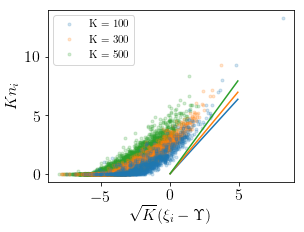

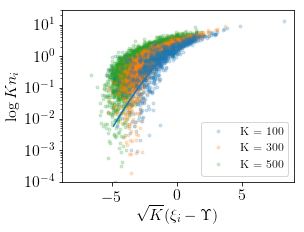

In [1223]:
bias_with_lambda1 = bias_array1 - lambda_array1
bias_with_lambda2 = bias_array2 - lambda_array2
bias_with_lambda3 = bias_array3 - lambda_array3


plt.figure(figsize=(4.5,3.5))
plt.plot(bias_with_lambda1.flatten(),n_mean_array1.flatten(),'.',zorder=-1,alpha=0.2,label='K = 100')
plt.plot(bias_with_lambda2.flatten(),n_mean_array2.flatten(),'.',zorder=-2,alpha=0.2,label='K = 300')
plt.plot(bias_with_lambda3.flatten(),n_mean_array3.flatten(),'.',zorder=-3,alpha=0.2,label='K = 500')

xvec = np.arange(0,5,.1)
plt.plot(xvec,-xvec/(gamma*chi1),color='C0')
plt.plot(xvec,-xvec/(gamma*chi2),color='C1')
plt.plot(xvec,-xvec/(gamma*chi3),color='C2')

# plt.yscale('log')
# plt.ylim((1e-4,10))
# plt.xlim((-7,7))

plt.ylabel(r'$K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \Upsilon)$')
plt.legend(prop={'size':11})

plt.tight_layout()
plt.savefig('bias_estimate_g08_lambda_linear.pdf')

plt.figure(figsize=(4.5,3.5))
plt.plot(bias_with_lambda1.flatten(),n_mean_array1.flatten(),'.',zorder=-1,alpha=0.2,label='K = 100')
plt.plot(bias_with_lambda2.flatten(),n_mean_array2.flatten(),'.',zorder=-2,alpha=0.2,label='K = 300')
plt.plot(bias_with_lambda3.flatten(),n_mean_array3.flatten(),'.',zorder=-3,alpha=0.2,label='K = 500')


xvec = np.arange(0,5,.1)
plt.plot(-xvec, 2*np.exp(-0.7*xvec**(4/3)),color='C0')

plt.yscale('log')
plt.ylim((1e-4,30))
# plt.xlim((-7,7))

plt.ylabel(r'$\log K n_i$')
plt.xlabel(r'$\sqrt{K}(\xi_i - \Upsilon)$')
plt.legend(prop={'size':12})

plt.tight_layout()
plt.savefig('bias_estimate_g08_lambda_log.pdf')

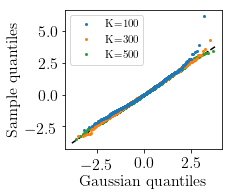

In [1227]:
plt.figure(figsize=(3.5,3))

(quantiles1, bias1_sorted), linear_fit = scipy.stats.probplot(bias_array1.flatten());

(quantiles2, bias2_sorted), linear_fit = scipy.stats.probplot(bias_array2.flatten());
(quantiles3, bias3_sorted), linear_fit = scipy.stats.probplot(bias_array3.flatten());

bias1_std = np.std(bias1_sorted)
plt.plot(quantiles1,bias1_sorted/bias1_std,'.',zorder=3,markersize=4,label='K=100')

bias2_std = np.std(bias2_sorted)
plt.plot(quantiles2,bias2_sorted/bias2_std,'.',zorder=2,markersize=4,label='K=300')

bias3_std = np.std(bias3_sorted)
plt.plot(quantiles3,bias3_sorted/bias3_std,'.',zorder=1,markersize=4,label='K=500')

xvec = np.arange(np.min(quantiles3)-.2,np.max(quantiles3)+.2,.1)
plt.plot(xvec,xvec,'k--',zorder=-1)

plt.legend(prop={'size':11})
plt.yticks([-2.5,0,2.5,5])

# plt.xticks([-2,0,2])

plt.ylabel('Sample quantiles')
plt.xlabel('Gaussian quantiles')

plt.tight_layout()
plt.savefig('bias_estimate_g08_quantiles.pdf')

## Data with $\gamma = -0.95$

* K = 100
* M = 20
* gamma = -0.95
* D = 4 to 40

In [2]:
# Load data.  K = 100, gamma = -0.95

data = np.load('theory_compare.npz')

D_num = 10
D_vec = data['D_vec']
bias1_array = data['bias1_array']  #Estimating chi with E[V<n>]
bias2_array = data['bias2_array']  #Using rank of <n>
n_mean_array = data['n_mean_array']
n_err_array = data['n_err_array']
lambda_vec = data['lambda_vec']
chi_vec = data['chi_vec']
K = data['K']
gamma = data['gamma']

In [3]:
lambda_vec

array([0.49498441, 0.46403941, 0.46235757, 0.46140117, 0.46195972,
       0.46123855, 0.46123388, 0.4611399 , 0.46099225, 0.46096812])

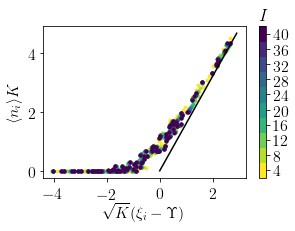

In [6]:
# Plot of n_mean vs bias1 of D_ind = 9 (the most islands)
plot_type = 'linear'
# plot_type = 'log'

fig = plt.figure(figsize=(4.5,3.5))
ax = fig.add_subplot(1,1,1)
cvec = D_vec

norm = mpl.colors.Normalize(vmin=np.min(cvec)-2, vmax=np.max(cvec)+2)
cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
colors = cmap(norm(cvec))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])



for D_ind in range(D_num):
    ax.plot(bias1_array[D_ind,:]-lambda_vec[D_ind],n_mean_array[D_ind,:],'.',color=colors[D_ind])

clb = plt.colorbar(sm,ticks = D_vec) 
    
if plot_type=='linear':
    vec = np.arange(0,3,.1)
    plt.plot(vec,-vec/(gamma*chi_vec[-1]),'k')

if plot_type=='log':
    vec = np.arange(0,3,.1)
    plt.plot(-vec,np.exp(-2*vec**(4/3)),'k')

    plt.yscale('log')
    plt.ylim((1e-4,10))
    plt.xlim((-3,3))

    
plt.xlabel(r'$\sqrt{K}(\xi_i - \Upsilon)$')
plt.ylabel(r'$\langle n_i \rangle K$')
clb.ax.set_title(r'$I$')
plt.tight_layout()

plt.savefig('figures/estimated_bias_unordered_linear_naturalnorm_I.pdf')

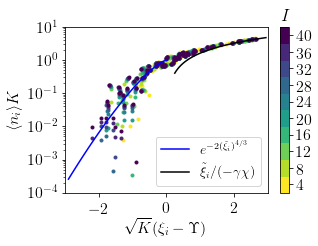

In [30]:
# Plot of n_mean vs bias1 of D_ind = 9 (the most islands)
plot_type = 'log'


fig = plt.figure(figsize=(4.8,3.7))
ax = fig.add_subplot(1,1,1)
cvec = D_vec

norm = mpl.colors.Normalize(vmin=np.min(cvec)-2, vmax=np.max(cvec)+2)
cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
colors = cmap(norm(cvec))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])



for D_ind in range(D_num):
    ax.plot(bias1_array[D_ind,:]-lambda_vec[D_ind],n_mean_array[D_ind,:],'.',color=colors[D_ind])

clb = plt.colorbar(sm,ticks = D_vec) 
    
if plot_type=='linear':
    vec = np.arange(0,3,.1)
    plt.plot(vec,-vec/(gamma*chi_vec[-1]),'k')

if plot_type=='log':
    vec = np.arange(0.0,3,.1)
    plt.plot(-vec,np.exp(-2*vec**(4/3)),'blue',label=r'$e^{-2(\tilde{\xi}_{i})^{4/3}}$')
    
    vec_2 = np.arange(0.25,3,0.05)
    plt.plot(vec_2,-vec_2/(gamma*chi_vec[-1]),'k',label=r'$\tilde{\xi}_{i}/(-\gamma\chi)$')

    plt.yscale('log')
    plt.ylim((1e-4,10))
    plt.xlim((-3,3))
    
    plt.legend(fontsize=14)

    
plt.xlabel(r'$\sqrt{K}(\xi_i - \Upsilon)$')
plt.ylabel(r'$\langle n_i \rangle K$')
clb.ax.set_title(r'$I$')
plt.tight_layout()

plt.savefig('figures/estimated_bias_unordered_log_labelled_naturalnorm_I.pdf')

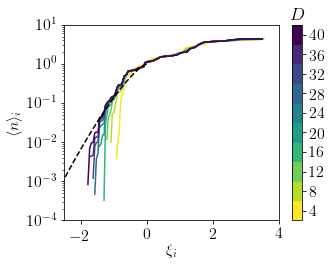

In [371]:
# Log plot of n_mean vs bias2

plot_type = 'linear'
plot_type = 'log'

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
cvec = D_vec

norm = mpl.colors.Normalize(vmin=np.min(cvec)-2, vmax=np.max(cvec)+2)
cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
colors = cmap(norm(cvec))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


for D_ind in range(D_num):
    sort_index = np.argsort(bias2_array[D_ind,:])
    bias = bias2_array[D_ind,sort_index]-lambda_vec[D_ind]
    n_mean = n_mean_array[D_ind,sort_index]
    ax.plot(bias[n_mean>1e-5],n_mean[n_mean>1e-5],'-',color=colors[D_ind])

clb = plt.colorbar(sm,ticks = D_vec) 

if plot_type=='linear':
    vec = np.arange(0,3,.1)
    plt.plot(vec,-vec/(gamma*chi_vec[-1]),'k')

if plot_type=='log':
    vec = np.arange(0,3,.1)
    plt.plot(-vec,np.exp(-2*vec**(4/3)),'k--')

    plt.yscale('log')
    plt.ylim((1e-4,10))
    plt.xlim((-2.5,4))
    
plt.xlabel(r'$\xi_i$')
plt.ylabel(r'$\langle n \rangle_i$')
clb.ax.set_title(r'$D$')
plt.tight_layout()

# plt.savefig('estimated_bias_ordered_log.pdf')

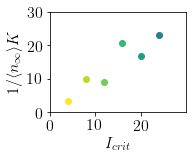

In [145]:
# Scaling of critical island number vs n_i (for 40 islands)
# Using bias2

n_mean_crit = np.zeros(D_vec.shape)

bias_array = bias2_array - np.reshape(lambda_vec,(D_num,1))

plt.figure(figsize=(3,2.5))

norm = mpl.colors.Normalize(vmin=np.min(cvec)-2, vmax=np.max(cvec)+2)
cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
colors = cmap(norm(cvec))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for D_ind in range(D_num):
    n_mean = n_mean_array[D_ind,:]
    n_mean[n_mean<1e-4] = np.inf
    bias2_crit = bias_array[D_ind,np.argmin(n_mean)]
    n_min_ind = np.argmin(n_mean)
#     n_mean_crit[D_ind] = n_mean_array[-1,np.argmin((bias_array[-1,:]-bias2_crit)**2)]
    n_mean_crit[D_ind] = n_mean_array[-1,n_min_ind]
    
    plt.plot(D_vec[D_ind],1/n_mean_crit[D_ind],'o',color=colors[D_ind])

    
plt.ylim((0,30))
plt.xlim((0,30))

plt.xlabel(r'$I_{crit}$')
plt.ylabel(r'$1/\langle n_{\infty} \rangle K$')
plt.xticks([0,10,20])

plt.tight_layout()

plt.savefig('estimated_bias_D_crit_naturalnorm_crit.pdf')

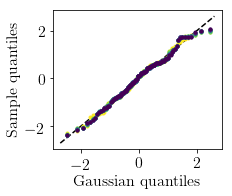

In [1205]:
plt.figure(figsize=(3.5,3))

cvec = D_vec

norm = mpl.colors.Normalize(vmin=np.min(cvec)-2, vmax=np.max(cvec)+2)
cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
colors = cmap(norm(cvec))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

num = bias1_array.shape[0]
for ind in range(num):
    (quantiles, bias_sorted), linear_fit = scipy.stats.probplot(bias1_array[ind,:]);

    bias_std = np.std(bias_sorted)
    plt.plot(quantiles,bias_sorted/bias_std,'.',color=colors[ind],markersize=6)


xvec = np.arange(-2.7,2.7,.1)
plt.plot(xvec,xvec,'k--',zorder=-1)

# plt.legend(prop={'size':11})
# plt.yticks([-2.5,0,2.5,5])

# plt.xticks([-2,0,2])

plt.ylabel('Sample quantiles')
plt.xlabel('Gaussian quantiles')

plt.tight_layout()

# plt.savefig('bias_estimate_quantiles.pdf')

# Fluctuations of island-average 
Data parameters:
* K = 50
* $M = 25$
* $\gamma = -0.8$
* Extinction threshold: essentially $\log n = -\infty$
* Time = 3000K

In [385]:
D_num = 9
L_ind = 0
rep_num = 5

x_max_array = np.zeros((rep_num,7,K))
n_mean_array = np.zeros((rep_num,7,K))
exp_array = np.zeros((rep_num,7,K))
xi_array = np.zeros((rep_num,7,K))

for rep_ind in range(rep_num):

    for D_ind in range(7):
        file_name = 'extinction_timescale_2018_08/data/extTime0_D{}_L{}_rep{}_dict.npz'.format(D_ind+1,L_ind,rep_ind)
        data = np.load(file_name)
        ET = data['ET'][()]
        K = ET['K']

        n_mean_array[rep_ind,D_ind,:] = np.mean(ET['n_mean'],axis=0)

        xbar = ET['xbar_list']
        counts = np.array(ET['histcounts_list'])
        dx = 0.01
        for ii in range(K):
            prob_density = counts[ii]/(np.sum(counts[ii])*dx)
            xbar_vec = xbar[ii]/ET['M']
            ind_max = np.argmax(prob_density)
            x_max = xbar_vec[ind_max]
            x_max_array[rep_ind,D_ind,ii] = x_max

            if x_max>-5:
                window = np.logical_and(np.logical_and(prob_density<.3,prob_density>3e-3),xbar_vec<x_max)
                coeff = np.polyfit(xbar_vec[window],np.log(prob_density[window]),1)
                exp_array[rep_ind,D_ind,ii] = coeff[0]

        vec = np.arange(-3,3,.001)
        xi_rank = (K/2)*(1+scipy.special.erf((vec)/np.sqrt(2)))

        n_mean = np.mean(ET['n_mean'],axis=0)
        sort_ind= np.argsort(n_mean)

In [387]:
exp_array.shape

(5, 7, 50)

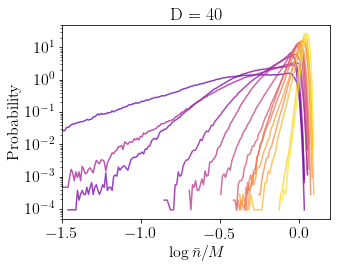

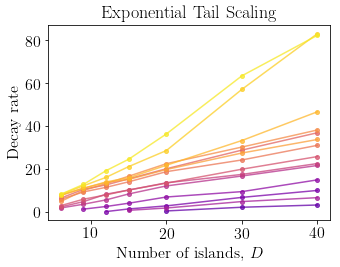

In [390]:
D_list = np.array([3, 6, 9, 12, 15, 20, 30, 40, 50])
D_vec = D_list[1:8]
rep_ind = 1

#find rank of n_mean for D = 40
D_ind =7
L_ind = 0
file_name = 'extinction_timescale_2018_08/data/extTime0_D{}_L{}_rep{}_dict.npz'.format(D_ind,L_ind,rep_ind)
data = np.load(file_name)
ET = data['ET'][()]
D = ET['D']
K = ET['K']
n_mean = np.mean(ET['n_mean'],axis=0)
n_mean_max = np.max(n_mean)

sort_ind = np.argsort(n_mean)

xbar = ET['xbar_list']
counts = np.array(ET['histcounts_list'])

plt.figure(figsize=(5,4))
for ii in range(9,K,3):
    ind = sort_ind[ii]
    xbar_vec = (xbar[ind]+np.log(K))/ET['M']
    dx = 0.01
    prob_density = counts[ind]/(np.sum(counts[ind])*dx)
    plt.plot(xbar_vec,prob_density,alpha=0.75,color=plt.cm.plasma(ii/K))

plt.xlim((-1.5,.2))
plt.yscale('log')
plt.xlabel(r'$\log \bar{n}/M$')
plt.ylabel(r'Probability')
plt.title(r'D = {}'.format(D))
plt.tight_layout()

plt.savefig('fluctuation_in_island_ave.pdf')

plt.figure(figsize=(5,4))
for ii in range(9,K,3):
    ind = sort_ind[ii]
    index= exp_array[rep_ind,:,ind]>0.01
    plt.plot(D_vec[index],exp_array[rep_ind,index,ind],'.-',markersize=8,alpha=0.75,color=plt.cm.plasma(ii/K))
    
#     if np.any(index):
#         index= exp_array[rep_ind,:,ii]>5
#         coeff = np.polyfit(D_vec[index],exp_array[rep_ind,index,ii],1)
    
#         plt.plot(D_vec,coeff[0]*D_vec + coeff[1],'--',color='C{}'.format(ii%9))
    
plt.xlabel(r'Number of islands, $D$')
plt.ylabel(r'Decay rate')
plt.title('Exponential Tail Scaling')
plt.tight_layout()

plt.savefig('tail_scaling_with_D.pdf')





In [384]:
exp_array.shape

(5, 7, 39)

# Rank Abundance Plot

In [185]:
data1 = np.load('phase_space0_mean_abundances.npz')
data1 = data1['data'][()]
print(data1.keys())

dict_keys(['lambda_mean_array', 'M', 'K', 'n_mean_array', 'D_vec', 'n2_mean_array', 'g_vec'])


In [186]:
data2 = np.load('phase_space0_snapshot_distribution.npz')
data2 = data2['data'][()]
print(data2.keys())

dict_keys(['x_vec', 'M', 'K', 'x_rank_array', 'D_vec', 'g_vec'])


In [196]:
K = data1['K']
# increased K for antisymmetric plots
#K = 150

M = data1['M']
D_vec = data1['D_vec']
g_vec = data1['g_vec']

x_rank_array = data2['x_rank_array']
x_vec = data2['x_vec']
n_mean_array = data1['n_mean_array']

print([D])

[10]


In [197]:
#Generate antisym rank abundance curve

#temp = .2*M
temp = M
beta = K/temp

dfbar = 0.01/K
fbar = np.arange(0,10/K,dfbar)
fbar = np.reshape(fbar,(1,len(fbar)))
sig2 = (2*np.pi)/K**2
fbar_prob = np.exp(-fbar**2/(2*sig2))/np.sqrt(2*np.pi*sig2)
fbar_prob = fbar_prob*(0.5)/np.sum(fbar_prob)

antisym_mean_rank = K/2 - K*np.cumsum(fbar_prob[0,:])
antisym_mean = fbar[0,:]

fvec = np.exp(x_vec)
dx = np.abs(x_vec[1]-x_vec[0])


prob_density_array = np.zeros((len(fvec),fbar.shape[1]))

for ii in range(fbar.shape[1]):
    prob_density1 = (1-fvec)**(beta*(1-fbar[0,ii])-1)*(fvec)**(beta*(fbar[0,ii]))
    prob_density_array[:,ii] = prob_density1/np.sum(prob_density1*dx)
    
prob_density = np.sum(prob_density_array*fbar_prob,axis=1)

antisym_snapshot_rank = K/2 - K*np.cumsum(prob_density*dx)


In [198]:
# Neutral prediction with neutral spectrum of mainland abundances

biodiv = 10  #biodiversity parameter

dfbar = 0.01/K
fbar = np.arange(dfbar,1,dfbar)
fbar = np.reshape(fbar,(1,len(fbar)))
sig2 = (2*np.pi)/K**2
fbar_prob = biodiv*(1-fbar)**(biodiv-1)/fbar

neutral_mean_rank = np.cumsum(fbar_prob[0,:]*dfbar)
neutral_mean_rank = np.sum(fbar_prob[0,:]*dfbar) - neutral_mean_rank
neutral_mean = fbar[0,:]

fvec = np.exp(x_vec)
dx = np.abs(x_vec[1]-x_vec[0])
mu = beta  # N m

prob_density_array = np.zeros((len(fvec),fbar.shape[1]))

for ii in range(fbar.shape[1]):
    prob_density1 = (1-fvec)**(mu*(1-fbar[0,ii])-1)*(fvec)**(mu*(fbar[0,ii]))
    prob_density_array[:,ii] = prob_density1/np.sum(prob_density1*dx)
    
prob_density = np.sum(prob_density_array*fbar_prob*dfbar,axis=1)

neutral_snapshot_rank = (np.sum(prob_density*dx)-np.cumsum(prob_density*dx))

In [199]:
# Neutral prediction with K/2 types with equal abundances on mainland

fbar = 2/K

neutral_mean_rank = np.arange(0,K/2,.1)
neutral_mean = fbar*np.ones(neutral_mean_rank.shape)

fvec = np.exp(x_vec)
dx = np.abs(x_vec[1]-x_vec[0])
mu = K/temp  # N m

prob_density_array = np.zeros((len(fvec)))

prob_density1 = (1-fvec)**(mu*(1-fbar)-1)*(fvec)**(mu*fbar)
prob_density = prob_density1/np.sum(prob_density1*dx)


neutral_snapshot_rank = K/2*(np.sum(prob_density*dx)-np.cumsum(prob_density*dx))

(-25, 3)

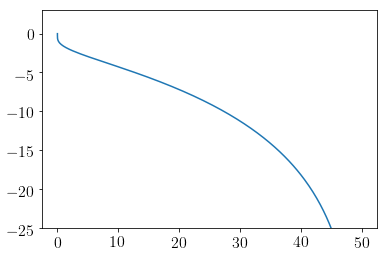

In [200]:
plt.plot(neutral_snapshot_rank,x_vec)
# plt.yscale('log')
plt.ylim((-25,3))


In [201]:
# load instantaneous rank-abundance curves

file_name = 'island_rank_abundance_paper'
with np.load(file_name+'.npz') as data:
    gammas = data['gammas']
    ranks = data['ranks']
    abunds = data['abunds']

In [202]:
gammas

array([-0.9, -0.8, -0.6])

D = 50.0


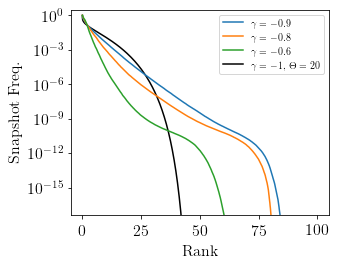

In [203]:
D_ind = 7
rep_ind =10
g_list = [0,1,2]

print('D = {}'.format(D_vec[D_ind]))


plt.figure(figsize=(5,4))
#for g_ind in g_list:
#    plt.plot(K-x_rank_array[D_ind,g_ind,rep_ind,:],np.exp(x_vec),label=r'$\gamma = {}$'.format(g_vec[g_ind]))

for i,gamma in enumerate(gammas):
    plt.plot(ranks[i],abunds[i],label=r'$\gamma = {}$'.format(gamma))

plt.plot(antisym_snapshot_rank,np.exp(x_vec),'k',label=r'$\gamma= -1$, $\Theta = {}$'.format(temp),zorder=-1)
# plt.plot(neutral_snapshot_rank,np.exp(x_vec),'k--',label=r'Neutral',zorder=-.5)

# plt.xscale('log')
plt.yscale('log')
# plt.xlim((-3,100))
plt.ylim((np.exp(-40),3))

plt.legend(prop = {'size':10})
plt.ylabel('Snapshot Freq.')
plt.xlabel('Rank')
# plt.title('Snapshot')
plt.tight_layout()

#plt.savefig('islands_rank_abundance0_snapshot_D{}_rep{}.pdf'.format(D_ind,rep_ind))
plt.savefig('figures/islands_rank_abundance_snapshot.pdf')

D = 50.0


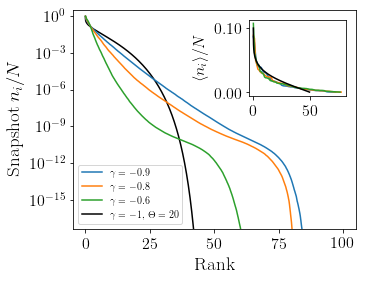

In [204]:
D_ind = 7
rep_ind =10
g_list = [0,1,2]

print('D = {}'.format(D_vec[D_ind]))


fig = plt.figure(figsize=(5.37,4.2))
#for g_ind in g_list:
#    plt.plot(K-x_rank_array[D_ind,g_ind,rep_ind,:],np.exp(x_vec),label=r'$\gamma = {}$'.format(g_vec[g_ind]))

for i,gamma in enumerate(gammas):
    plt.plot(ranks[i],abunds[i],label=r'$\gamma = {}$'.format(gamma))

plt.plot(antisym_snapshot_rank,np.exp(x_vec),'k',label=r'$\gamma= -1$, $\Theta = {}$'.format(temp),zorder=-1)
# plt.plot(neutral_snapshot_rank,np.exp(x_vec),'k--',label=r'Neutral',zorder=-.5)

# plt.xscale('log')
plt.yscale('log')
# plt.xlim((-3,100))
plt.ylim((np.exp(-40),3))

plt.legend(prop = {'size':10},loc='lower left')
plt.ylabel(r'Snapshot $n_{i}/N$',fontsize=19)
plt.xlabel('Rank',fontsize=19)
# plt.title('Snapshot')
plt.tight_layout()

#plt.savefig('islands_rank_abundance0_snapshot_D{}_rep{}.pdf'.format(D_ind,rep_ind))

ax1 = fig.add_axes([0.67, 0.65, 0.25, 0.25])

#plt.figure(figsize=(3,3))
for g_ind in g_list:
    n_mean_sort = np.sort(n_mean_array[D_ind,g_ind,rep_ind,:])[::-1]
    nonzero = n_mean_sort>0

    ax1.plot(np.arange(K)[nonzero],n_mean_sort[nonzero]/K,label=r'$\gamma = {}$'.format(g_vec[g_ind]))
    
ax1.plot(antisym_mean_rank,antisym_mean,'k-')
#plt.plot(neutral_mean_rank,neutral_mean,'k--')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim((.01,100))
# plt.ylim(((-25),3))

ax1.set_ylabel(r'$\langle n_{i}\rangle/N$')
#ax1.set_xlabel('Rank')
# plt.title('Average')

ax1.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
#ax1.tight_layout()

plt.savefig('figures/islands_rank_abundance_snapshot_inset.pdf')

In [ ]:


plt.figure(figsize=(3,3))
for g_ind in g_list:
    n_mean_sort = np.sort(n_mean_array[D_ind,g_ind,rep_ind,:])[::-1]
    nonzero = n_mean_sort>0

    plt.plot(np.arange(K)[nonzero],n_mean_sort[nonzero]/K,label=r'$\gamma = {}$'.format(g_vec[g_ind]))
    
plt.plot(antisym_mean_rank,antisym_mean,'k',zorder=-1)
# plt.plot(neutral_mean_rank,neutral_mean,'k--')
# plt.plot(neutral_mean_rank[neutral_mean<0.2],neutral_mean[neutral_mean<0.2])

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim((-5,100))
# plt.ylim((np.exp(-25),3))

plt.ylabel('Average Freq.')
plt.xlabel('Rank')
# plt.title('Average')

plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.tight_layout()

plt.savefig('islands_rank_abundance0_average_D{}_rep{}.pdf'.format(D_ind,rep_ind))

D = 50.0


KeyboardInterrupt: 

In [1237]:
#Generate antisym rank abundance curve

temp = M
beta = K/temp

dfbar = 0.01/K
fbar = np.arange(0,10/K,dfbar)
fbar = np.reshape(fbar,(1,len(fbar)))
sig2 = (2*np.pi)/K**2
fbar_prob = np.exp(-fbar**2/(2*sig2))/np.sqrt(2*np.pi*sig2)
fbar_prob = fbar_prob*(0.5)/np.sum(fbar_prob)

antisym_mean_rank = K/2 - K*np.cumsum(fbar_prob[0,:])
antisym_mean = fbar[0,:]

fvec = np.exp(x_vec)
dx = np.abs(x_vec[1]-x_vec[0])


prob_density_array = np.zeros((len(fvec),fbar.shape[1]))

for ii in range(fbar.shape[1]):
    prob_density1 = (1-fvec)**(beta*(1-fbar[0,ii])-1)*(fvec)**(beta*(fbar[0,ii]))
    prob_density_array[:,ii] = prob_density1/np.sum(prob_density1*dx)
    
prob_density = np.sum(prob_density_array*fbar_prob,axis=1)

antisym_snapshot_rank = K/2 - K*np.cumsum(prob_density*dx)

In [1238]:
# Neutral prediction with K/2 types with equal abundances on mainland

fbar = 2/K

neutral_mean_rank = np.arange(0,K/2,.1)
neutral_mean = fbar*np.ones(neutral_mean_rank.shape)

fvec = np.exp(x_vec)
dx = np.abs(x_vec[1]-x_vec[0])
mu = K/temp  # N m

prob_density_array = np.zeros((len(fvec)))

prob_density1 = (1-fvec)**(mu*(1-fbar)-1)*(fvec)**(mu*fbar)
prob_density = prob_density1/np.sum(prob_density1*dx)


neutral_snapshot_rank = K/2*(np.sum(prob_density*dx)-np.cumsum(prob_density*dx))

D = 12.0


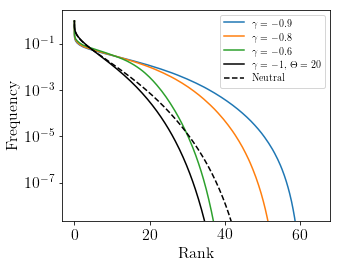

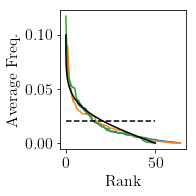

In [1239]:
D_ind = 2
rep_ind =10
g_list = [0,1,2]

print('D = {}'.format(D_vec[D_ind]))


plt.figure(figsize=(5,4))
for g_ind in g_list:
    plt.plot(K-x_rank_array[D_ind,g_ind,rep_ind,:],np.exp(x_vec),label=r'$\gamma = {}$'.format(g_vec[g_ind]))
    
plt.plot(antisym_snapshot_rank,np.exp(x_vec),'k',label=r'$\gamma= -1$, $\Theta = {}$'.format(temp))
plt.plot(neutral_snapshot_rank,np.exp(x_vec),'k--',label=r'Neutral')

# plt.xscale('log')
plt.yscale('log')
# plt.xlim((.01,100))
plt.ylim((np.exp(-20),3))

plt.legend(prop = {'size':10})
plt.ylabel('Frequency')
plt.xlabel('Rank')
# plt.title('Snapshot')
plt.tight_layout()

# plt.savefig('islands_rank_abundance1_snapshot_D{}_rep{}.pdf'.format(D_ind,rep_ind))

plt.figure(figsize=(3,3))
for g_ind in g_list:
    n_mean_sort = np.sort(n_mean_array[D_ind,g_ind,rep_ind,:])[::-1]
    nonzero = n_mean_sort>0

    plt.plot(np.arange(K)[nonzero],n_mean_sort[nonzero]/K,label=r'$\gamma = {}$'.format(g_vec[g_ind]))
    
plt.plot(antisym_mean_rank,antisym_mean,'k-')
plt.plot(neutral_mean_rank,neutral_mean,'k--')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlim((.01,100))
# plt.ylim(((-25),3))

plt.ylabel('Average Freq.')
plt.xlabel('Rank')
# plt.title('Average')

plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.tight_layout()

# plt.savefig('islands_rank_abundance1_average_D{}_rep{}.pdf'.format(D_ind,rep_ind))

# Rank Abundance after extinctions
Data details:
* D = 50
* K = 100
* M = 50
* $\gamma = -0.8$
* Extinction threshold: $\log n = -1.3M$
* Procedure for extinctions:
    * Island-average abundance $\bar{n}$ calculated over a time 50$K$.
    * If no extinctions occured during time period, then lowest $\bar{n}$ removed.
    * If extinctions did occur, then no additional species are removed.
    * Also have data in which species with lowest fluctuation in $\bar{n}$ is removed.

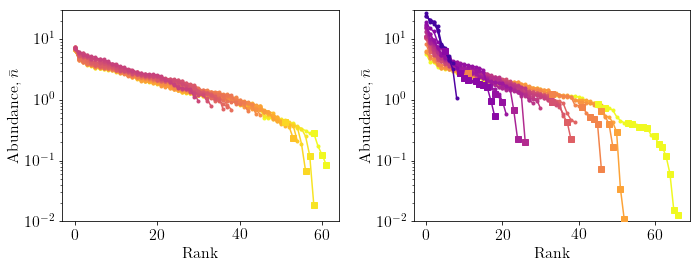

In [392]:
L_ind = 0
meth_ind = 0

L_vec = [.3,.1]
meth_vec = ['mean', 'min']

rep_vec = [7,6]
rep_num = len(rep_vec)

plt.figure(figsize=(2*5,1*4))
for ii in range(rep_num):
    rep_ind = rep_vec[ii]
    plt.subplot(1,2,ii+1)
    
    
    
    file_name = 'extinction_timescale_2018_08/data/extTime2_L{}_meth{}_rep{}_dict.npz'.format(L_ind,meth_ind,rep_ind)
    if os.path.isfile(file_name):
        data = np.load(file_name)
        ET = data['ET'][()]
        
        L = L_vec[L_ind]
        meth = meth_vec[meth_ind]
        thresh = ET['thresh']/ET['M']

        n_mean = np.mean(ET['n_mean_array'],axis=1)
        going_extinct = np.isfinite(ET['extinct_time_array'])
        n_mean[going_extinct]*50/ET['extinct_time_array'][going_extinct]
        
        ext_times = ET['extinct_time_array']

        epoch_max = np.max(np.arange(ET['epoch_num'])[ET['reset_number_array']==0])

        for epoch in range(epoch_max):

            index = n_mean[epoch]>0
            sort_ind = np.argsort(n_mean[epoch,index])[::-1]
            n_mean_sorted = n_mean[epoch,index][sort_ind]
            rank = np.arange(len(n_mean_sorted))

        #     index = n_mean_sorted>0
            plt.plot(rank,n_mean_sorted,'.-',color=plt.cm.plasma(len(n_mean_sorted)/ET['K1']),alpha=1)
            
            index2 = np.logical_and(index,going_extinct[epoch])
            index3 = index2[index][sort_ind]
            plt.plot(rank[index3],n_mean_sorted[index3],'s',color=plt.cm.plasma(len(n_mean_sorted)/ET['K1']),alpha=1,zorder=300)

        plt.yscale('log')
        plt.ylim((1e-2,30))
#         plt.xlim((-2,40))
        

#         plt.title('L = {:.1f}, method = {}, rep={}'.format(L,meth,rep_ind))
        plt.xlabel('Rank')
        plt.ylabel(r'Abundance, $\bar{n}$')
            
plt.tight_layout()
# plt.savefig('rank_abundance_extinction.pdf')

Plot above: Shows rank-abundance curves after each epoch of length $50K$. Curves are colored by the number of non-extinct species. Square indicate species that went extinct because of the extinction threshold instead of being removed by hand.

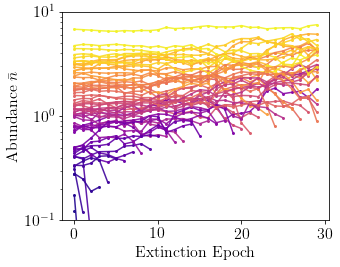

In [294]:
L_ind = 0
meth_ind = 0
rep_ind = 7
np.random.seed(10)
plt.figure(figsize=(5,4))

file_name = 'extinction_timescale_2018_08/data/extTime2_L{}_meth{}_rep{}_dict.npz'.format(L_ind,meth_ind,rep_ind)
data = np.load(file_name)
ET = data['ET'][()]

n_mean = np.mean(ET['n_mean_array'],axis=1)
n_mean[n_mean==0] = np.nan
reset_num = ET['reset_number_array']

ext_byhand_epoch = np.arange(ET['epoch_num'])[np.isfinite(ET['extinct_byhand_ind_array'])] + 0.5

sort_ind = np.argsort(n_mean[0,:])

reset_max = int(reset_num[-1]+1)
for reset in range(reset_max):
#     plt.figure()
    
    index = reset_num == reset 
    
    for ii in range(ET['K1']):
        ind = sort_ind[ii]
        plt.plot(n_mean[index,ind],'.-',markersize=4,alpha = .9,color = plt.cm.plasma(ii/ET['K1']),zorder=np.random.rand())
        

    plt.yscale('log')
    plt.ylabel(r'Abundance $\bar{n}$')
    plt.xlabel('Extinction Epoch')
#     plt.title('Reset {}'.format(reset))
    plt.ylim((1e-1,10))
    plt.tight_layout()

Plot above: Plot showing how the island-averaged abundance $\bar{n}$ changes after each extinction epoch of time $50K$. Each species is colored by the rank of its initial abundance before any extinctions by hand.

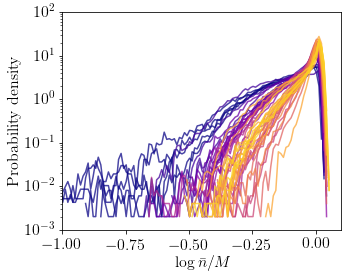

In [310]:
L_ind = 0
meth_ind = 0
rep_ind = 7
np.random.seed(10)
plt.figure(figsize=(5,4))

file_name = 'extinction_timescale_2018_08/data/extTime2_L{}_meth{}_rep{}_dict.npz'.format(L_ind,meth_ind,rep_ind)
data = np.load(file_name)
ET = data['ET'][()]

n_mean = np.mean(ET['n_mean_array'],axis=1)
n_mean[n_mean==0] = np.nan


for epoch in range(0,ET['epoch_num'],3):
    sort_ind = np.argsort(n_mean[epoch,:])
    for ii in range(0,5):
        ind = sort_ind[ii]
        hist_dict = ET['histogram_dict'][epoch][ind]
        xbar = (hist_dict['xbar']+np.log(ET['K']))/ET['M']
        counts = hist_dict['counts']
        dx = 0.01
        prob_density = counts/(np.sum(counts)*dx)
        plt.plot(xbar,prob_density,color =plt.cm.plasma(epoch/ET['epoch_num']),alpha=0.75 )
        plt.yscale('log')
    thresh = ET['thresh']/ET['M']
    vec = 1e3*np.arange(2)
    plt.plot(vec*0 + thresh,vec,'k--',alpha=0.3)
    
#     plt.title('Epoch {}'.format(epoch))
    plt.xlabel(r'$\log \bar{n} / M$')
    plt.ylabel('Probability density')
    plt.xlim((-1,.1))
    plt.ylim((1e-3,100))

# Extinction Time Scaling

## Fixed M, varying D

In [205]:
data = np.load('extinction_time_data.npz')
extinct_times_list = data['extinct_times_list'] #time in natural normalization
num_islands_list = data['num_islands_list']
M = data['M']
logN = data['logN']

In [206]:
# Add data from run with D = 100

data2 = np.load('extTimeLong_add_data.npz')
exttimes_sorted = np.reshape(data2['exttimes_sorted'],(1,1000))
extinct_times_list = np.append(extinct_times_list,exttimes_sorted,axis=0)
num_islands_list = np.append(num_islands_list,data2['D'])
K = data2['K']

In [207]:
num_islands_list

array([  8,  12,  16,  20,  24,  28,  32,  36,  40, 100])

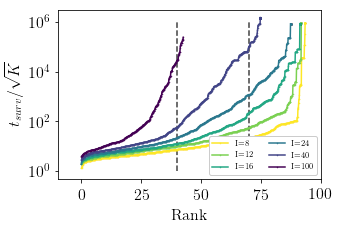

In [99]:
rep_num = 10
D_vec = num_islands_list
D_num = len(D_vec)

D_indices = [0,1,2,4,8,9]   #D values to plot

# Colorbar
# cvec = D_vec
# norm = mpl.colors.Normalize(vmin=np.min(cvec), vmax=np.max(cvec))
# cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
# colors = cmap(norm(cvec))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# Colors 
cmap = mpl.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,len(D_indices)))

fig = plt.figure(figsize=(5,3.5))

plot_counter = 0
for D_ind in D_indices:

    
    exttimes_sort = extinct_times_list[D_ind]
    max_time = exttimes_sort[-1]
    
    rank = np.arange(len(exttimes_sort))/rep_num
    max_rank = np.min(rank[exttimes_sort==max_time])
    rank[exttimes_sort==max_time] = max_rank
        
    plt.plot(rank,exttimes_sort/(np.sqrt(K)),'.-',color=colors[plot_counter],markersize=1,label='I={}'.format(D_vec[D_ind]))
    plot_counter +=1
    
plt.yscale('log')
plt.xlim((-10,100))
plt.xticks([0,25,50,75,100])
plt.yticks([1,1e2, 1e4, 1e6])
# plt.title(r'M = {}, $\log N$ = {}'.format(M,logN))
plt.ylabel(r'$t_{surv}/\sqrt{K}$')
plt.xlabel(r'Rank')
plt.legend(prop={'size':8},ncol = 2,loc='lower right',framealpha=1)

# Colorbar
# clb = plt.colorbar(sm,ticks=cvec)
# clb.ax.set_title(r'$I$')
plt.tight_layout()

r = 40
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(1),np.log(3e6)))
plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)

r = 70
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(1),np.log(3e6)))
plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)
    
# plt.savefig('survival_time_M20_logN30_naturalnorm.pdf')



In [100]:
cmap = mpl.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,len(D_indices)))

/home/atish/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/atish/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


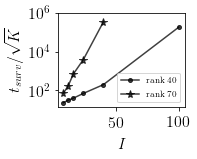

In [101]:
#Binning extinction times by rank
D_num = len(num_islands_list)
K = 100
    
dK = 2.5
rank_bins = [40, 70]
rank_color= ['C0','C3']
extinct_times_binned = np.zeros((D_num,len(rank_bins)))

plt.figure(figsize=(3,2.5))

cvec = D_vec
norm = mpl.colors.Normalize(vmin=np.min(cvec)-2, vmax=np.max(cvec)+2)
cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
colors = cmap(norm(cvec))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# D_indices = list(range(D_num))
D_indices = [0,1,2,4,8,9]
for D_ind in D_indices:
    exttimes_sort = extinct_times_list[D_ind]
    max_time = exttimes_sort[-1]
    
    rank = np.arange(len(exttimes_sort))/rep_num
    max_rank = np.min(rank[exttimes_sort==max_time])
    rank[exttimes_sort==max_time] = max_rank
    
#     rank_list.append(rank)
    
    for ii in range(len(rank_bins)):
        bin_index = np.logical_and(rank<rank_bins[ii]+dK,rank>=rank_bins[ii]-dK)
        extinct_times_binned[D_ind,ii] = np.mean(exttimes_sort[bin_index])

        
# for ii in range(len(rank_bins)):
#     for D_ind in range(D_num):
#         plt.plot(num_islands_list[D_ind],extinct_times_binned[D_ind,ii]/(M*np.sqrt(K)),'o-',color=colors[D_ind],label='{}'.format(rank_bins[ii]))

ii = 0
    
num_islands = num_islands_list[D_indices]
extinct_times = extinct_times_binned[D_indices,ii]/(np.sqrt(K))
plt.plot(num_islands,extinct_times,'k.-',markersize = 8,label='rank {}'.format(rank_bins[ii]),alpha=0.75)

ii = 1
    
num_islands = num_islands_list[D_indices]
extinct_times = extinct_times_binned[D_indices,ii]/(np.sqrt(K))
plt.plot(num_islands,extinct_times,'k*-',markersize = 8,label='rank {}'.format(rank_bins[ii]),alpha=0.75)


plt.yscale('log')
# plt.xlim((0,100))
# plt.ylim((1,1e6))
# plt.xticks([0,20,40])
plt.yticks([1e2,1e4,1e6])
# plt.yticks([1,1e2,1e4])
plt.ylabel(r'$t_{surv}/\sqrt{K}$')
plt.xlabel(r'$I$')
plt.legend(prop={'size':9})
plt.tight_layout()
# plt.savefig('survival_time_slice_M20_logN30_naturalnorm.pdf')
# plt.legend()

/home/atish/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/atish/.local/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


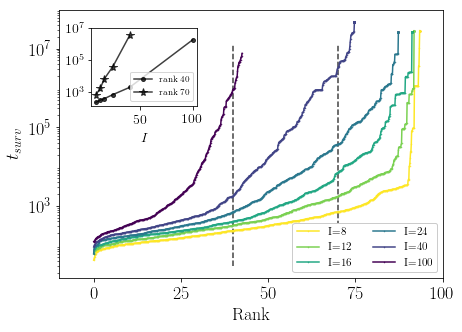

In [223]:
rep_num = 10
D_vec = num_islands_list
D_num = len(D_vec)

D_indices = [0,1,2,4,8,9]   #D values to plot

# Colorbar
# cvec = D_vec
# norm = mpl.colors.Normalize(vmin=np.min(cvec), vmax=np.max(cvec))
# cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
# colors = cmap(norm(cvec))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

# Colors 
cmap = mpl.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,len(D_indices)))

fig = plt.figure(figsize=(6.7,4.9))

plot_counter = 0
for D_ind in D_indices:

    
    exttimes_sort = extinct_times_list[D_ind]
    max_time = exttimes_sort[-1]
    
    rank = np.arange(len(exttimes_sort))/rep_num
    max_rank = np.min(rank[exttimes_sort==max_time])
    rank[exttimes_sort==max_time] = max_rank
        
    plt.plot(rank,exttimes_sort,'.-',color=colors[plot_counter],markersize=1,label='I={}'.format(D_vec[D_ind]))
    plot_counter +=1
    
plt.yscale('log')
plt.xlim((-10,100))
plt.xticks([0,25,50,75,100])
plt.yticks([1e1, 1e3, 1e5,1e7])
plt.tick_params(labelsize=18)
# plt.title(r'M = {}, $\log N$ = {}'.format(M,logN))
plt.ylabel(r'$t_{surv}$',fontsize=18)
plt.xlabel(r'Rank',fontsize=18)
plt.legend(prop={'size':11},ncol = 2,loc='lower right',framealpha=1)

# Colorbar
# clb = plt.colorbar(sm,ticks=cvec)
# clb.ax.set_title(r'$I$')
plt.tight_layout()

r = 40
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(30),np.log(3e7)))
plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)

r = 70
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(30),np.log(3e7)))
plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)
    
# plt.savefig('survival_time_M20_logN30_naturalnorm.pdf')

ax1 = fig.add_axes([0.21,0.67,0.22,0.22])

#Binning extinction times by rank
D_num = len(num_islands_list)
K = 100

dK = 2.5
rank_bins = [40, 70]
rank_color= ['C0','C3']
extinct_times_binned = np.zeros((D_num,len(rank_bins)))


cvec = D_vec
norm = mpl.colors.Normalize(vmin=np.min(cvec)-2, vmax=np.max(cvec)+2)
cmap = mpl.cm.get_cmap('viridis_r',len(cvec))
colors = cmap(norm(cvec))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# D_indices = list(range(D_num))
D_indices = [0,1,2,4,8,9]
for D_ind in D_indices:
    exttimes_sort = extinct_times_list[D_ind]
    max_time = exttimes_sort[-1]
    
    rank = np.arange(len(exttimes_sort))/rep_num
    max_rank = np.min(rank[exttimes_sort==max_time])
    rank[exttimes_sort==max_time] = max_rank
    
#     rank_list.append(rank)
    
    for ii in range(len(rank_bins)):
        bin_index = np.logical_and(rank<rank_bins[ii]+dK,rank>=rank_bins[ii]-dK)
        extinct_times_binned[D_ind,ii] = np.mean(exttimes_sort[bin_index])

        
# for ii in range(len(rank_bins)):
#     for D_ind in range(D_num):
#         plt.plot(num_islands_list[D_ind],extinct_times_binned[D_ind,ii]/(M*np.sqrt(K)),'o-',color=colors[D_ind],label='{}'.format(rank_bins[ii]))

ii = 0
    
num_islands = num_islands_list[D_indices]
extinct_times = extinct_times_binned[D_indices,ii]
plt.plot(num_islands,extinct_times,'k.-',markersize = 8,label='rank {}'.format(rank_bins[ii]),alpha=0.75)

ii = 1
    
num_islands = num_islands_list[D_indices]
extinct_times = extinct_times_binned[D_indices,ii]
plt.plot(num_islands,extinct_times,'k*-',markersize = 8,label='rank {}'.format(rank_bins[ii]),alpha=0.75)


ax1.set_yscale('log')
# plt.xlim((0,100))
# plt.ylim((1,1e6))
# plt.xticks([0,20,40])
ax1.set_yticks([1e3,1e5,1e7])
ax1.tick_params(labelsize=14)
# plt.yticks([1,1e2,1e4])
#ax1.set_ylabel(r'$t_{surv}/\sqrt{K}$')
ax1.set_xlabel(r'$I$',fontsize=14)
ax1.legend(prop={'size':9})
#ax1.tight_layout()

plt.savefig('figures/survival_times_inset.pdf')
# plt.legend()

## Fixed D, varying M

In [149]:
# data from extTimeLong2 run for M = 5, 10  and D = 3 to 100

data = np.load('extTimeLong2_data.npz')
extinct_times_dict = data['exttimes_sorted_dict'].item() #time in natural normalization. Dictionary with key (M_ind,D_ind) tuple
rank_dict = data['rank_dict'].item()
M_list = data['M_list']
D_list = data['D_list']
K = data['K']

# data from extTimeLong1  for M = 20  and D = 8 to 40.

data2 = np.load('extinction_time_data.npz')
extinct_times_list2 = data2['extinct_times_list'] #time in natural normalization
rank_list2 = data2['rank_list']
D_list2 = data2['num_islands_list']
M_list = np.append(M_list,data2['M'])

## Add data with same D values to dictionary of extinction times.
for D_ind in range(len(D_list2)):
    D = D_list2[D_ind]
    if np.isin(D,D_list):
        ind = int(np.arange(len(D_list))[D_list==D])
        extinct_times_dict[2,ind] = extinct_times_list2[D_ind,:]
        rank_dict[2,ind] = rank_list2[D_ind,:]
    
# # data from extTimeLong_add  for M = 20  and D = 100

data3 = np.load('extTimeLong_add_data.npz')
ind = int(np.arange(len(D_list))[D_list==data3['D']])
extinct_times_dict[2,ind] = data3['exttimes_sorted']
rank_dict[2,ind] = data3['rank']

print(D_list)

[  3.   5.   8.  12.  16.  24.  40. 100.]


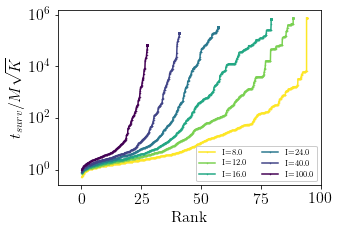

In [338]:
M_ind = 1
M = M_list[M_ind]
# Colors 
cmap = mpl.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,len(D_indices)))

plt.figure(figsize=(5,3.5))

plot_counter = 0
for D_ind in range(2,len(D_list)):
    
    exttimes_sort = extinct_times_dict[M_ind,D_ind]
    max_time = exttimes_sort[-1]
    
#     rank = np.arange(len(exttimes_sort))/rep_num
    rank = rank_dict[M_ind,D_ind]
    max_rank = np.min(rank[exttimes_sort==max_time])
    rank[exttimes_sort==max_time] = max_rank
        
    plt.plot(rank,exttimes_sort/(M*np.sqrt(K)),'.-',color=colors[plot_counter],markersize=1,label='I={}'.format(D_list[D_ind]))
    plot_counter +=1
    
plt.yscale('log')
plt.xlim((-10,100))
plt.xticks([0,25,50,75,100])
plt.yticks([1,1e2, 1e4, 1e6])
# plt.title(r'M = {}, $\log N$ = {}'.format(M,logN))
plt.ylabel(r'$t_{surv}/M\sqrt{K}$')
plt.xlabel(r'Rank')
plt.legend(prop={'size':8},ncol = 2,loc='lower right',framealpha=1)

# Colorbar
# clb = plt.colorbar(sm,ticks=cvec)
# clb.ax.set_title(r'$I$')
plt.tight_layout()

r = 40
vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
# vec = np.exp(np.arange(np.log(1),np.log(3e6)))
# plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)

r = 70
vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
# vec = np.exp(np.arange(np.log(1),np.log(3e6)))
# plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)
    
plt.savefig('survival_time_M10_logN30_longtime.pdf')

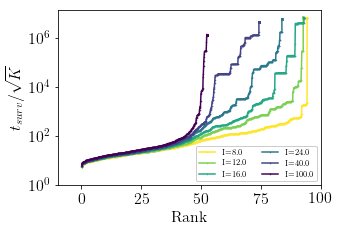

In [340]:
M_ind = 0
M = M_list[M_ind]

# Colors 
cmap = mpl.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,len(D_indices)))

plt.figure(figsize=(5,3.5))

plot_counter = 0
for D_ind in range(2,len(D_list)):
    
    exttimes_sort = extinct_times_dict[M_ind,D_ind]
    max_time = exttimes_sort[-1]
    
#     rank = np.arange(len(exttimes_sort))/rep_num
    rank = rank_dict[M_ind,D_ind]
    max_rank = np.min(rank[exttimes_sort==max_time])
    rank[exttimes_sort==max_time] = max_rank
        
    plt.plot(rank,exttimes_sort/(np.sqrt(K)),'.-',color=colors[plot_counter],markersize=1,label='I={}'.format(D_list[D_ind]))
    plot_counter +=1
    
plt.yscale('log')
plt.xlim((-10,100))
plt.xticks([0,25,50,75,100])
plt.yticks([1,1e2, 1e4, 1e6])
# plt.title(r'M = {}, $\log N$ = {}'.format(M,logN))
plt.ylabel(r'$t_{surv}/\sqrt{K}$')
plt.xlabel(r'Rank')
plt.legend(prop={'size':8},ncol = 2,loc='lower right',framealpha=1)

# Colorbar
# clb = plt.colorbar(sm,ticks=cvec)
# clb.ax.set_title(r'$I$')
plt.tight_layout()

r = 40
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(1),np.log(3e6)))
# plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)

r = 70
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(1),np.log(3e6)))
# plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)
    
plt.savefig('survival_time_M5_logN30_naturalnorm.pdf')

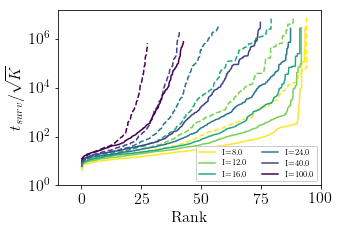

In [1276]:
M_ind = 1

# # Colors 
cmap = mpl.cm.get_cmap('viridis_r')
colors = cmap(np.linspace(0,1,len(D_indices)))
# colors = ['C{}'.format(i) for i in range(len(D_indices))]

plt.figure(figsize=(5,3.5))


for M_ind in [1,2]:
    plot_counter = 0
    for D_ind in range(2,len(D_list)):
        
        M = M_list[M_ind]

        exttimes_sort = extinct_times_dict[M_ind,D_ind]
        max_time = exttimes_sort[-1]

    #     rank = np.arange(len(exttimes_sort))/rep_num
        rank = rank_dict[M_ind,D_ind]
        max_rank = np.min(rank[exttimes_sort==max_time])
        rank[exttimes_sort==max_time] = max_rank

        if M_ind == 2:
            plt.plot(rank,exttimes_sort/(np.sqrt(K)),'-',alpha=1,color=colors[plot_counter],markersize=1,label='I={}'.format(D_list[D_ind]))
        else:
            plt.plot(rank,exttimes_sort/(np.sqrt(K)),'--',color=colors[plot_counter],markersize=1)
        plot_counter +=1
        
    
plt.yscale('log')
plt.xlim((-10,100))
plt.xticks([0,25,50,75,100])
plt.yticks([1,1e2, 1e4, 1e6])
# plt.title(r'M = {}, $\log N$ = {}'.format(M,logN))
plt.ylabel(r'$t_{surv}/\sqrt{K}$')
plt.xlabel(r'Rank')
plt.legend(prop={'size':8},ncol = 2,loc='lower right',framealpha=1)

# Colorbar
# clb = plt.colorbar(sm,ticks=cvec)
# clb.ax.set_title(r'$I$')
plt.tight_layout()

r = 40
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(1),np.log(3e6)))
# plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)

r = 70
# vec = np.exp(np.arange(np.log(0.1),np.log(3e5)))
vec = np.exp(np.arange(np.log(1),np.log(3e6)))
# plt.plot(r+0*vec,vec,'--',color='k',zorder=-1,alpha=0.75)
    
plt.savefig('survival_time_M10_logN30_comparison_naturalnorm.pdf')

## Extinction time vs n_ave

In [1294]:

# Data from extTimeLong_add with M = 20 and D = 100

# data = np.load('extTimeLong_add_data.npz')
# exttimes_array = data['exttimes_array']
# K = data['K']

# Combined Data for runs with M = 5,10,20 and D = 3 to 100
data3 = np.load('extTimeLong2_data.npz')
exttimes_array2 = data3['exttimes_array']
D_list = data3['D_list']

# Data for "infinite islands" case (D = 100 with no extinction threshold) with M = 5, 10, 20

data2 = np.load('extTimeLong_inf_data.npz')
M_list = data2['M_list']
n_mean_dict = data2['n_mean_dict'].item()  #dictionary with key (M_ind,rep_ind) tuple
K = data2['K']



40.0


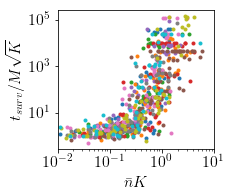

In [1306]:
K = 100
M_ind = 2
D_ind = 6
print(D_list[D_ind])
M = M_list[M_ind]

plt.figure(figsize=(3.5,3))
for rep_ind in range(10):
    n_means = np.array(n_mean_dict[M_ind,rep_ind])  #
    n_means = np.mean(n_means[1:,:],axis=0)

    index = n_means>1e-4
    plt.plot(n_means[index],exttimes_array2[M_ind,D_ind,rep_ind,index]/(M*np.sqrt(K)),'.')
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$t_{surv}/M\sqrt{K}$')
plt.xlabel(r'$\bar{n} K$')
plt.xlim((1e-2,10))
plt.tight_layout()
# plt.savefig('survival_time_vs_nbar_M20_D40_longtime.pdf')

In [282]:
exttimes_array2.shape

(2, 8, 10, 100)

# Scaling of number of surviving species

## Phase_space0: Scaling with Islands
* K = 100
* D = [4,8,12,16,20,24,30,50,100]
* gamma = [-0.9,-0.8,-0.6,-0.4,-0.2,0]
* Averages over 20 instantiations

In [1261]:
data = np.load('phase_space0_mean_abundances.npz')
data = data['data'][()]
print(data.keys())

data2 = np.load('phase_space0_D8_data.npz')

dict_keys(['g_vec', 'K', 'lambda_mean_array', 'M', 'n2_mean_array', 'D_vec', 'n_mean_array'])


In [1262]:
K = data['K']
M = data['M']
n_mean_array = data['n_mean_array']
D_vec = data['D_vec']
g_vec = data['g_vec']

n_mean_array2 = data2['n_mean_array']
(a,b,c) = np.shape(n_mean_array2)
n_mean_array2 = np.reshape(n_mean_array2,(1,a,b,c))
D = data2['D_list'][8]
n_mean_array = np.append(n_mean_array,n_mean_array2,axis=0)
D_vec = np.append(D_vec,D)

(D_num, g_num, rep_num, K) = n_mean_array.shape

In [1263]:
D_vec

array([  4.,   8.,  12.,  16.,  20.,  24.,  30.,  50., 100.])

(-100, 0)

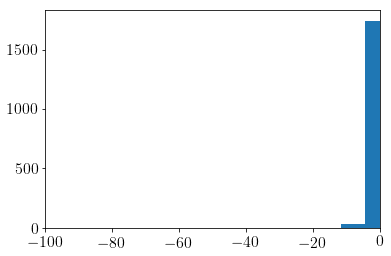

In [1264]:
n_mean = n_mean_array[8,1].flatten()
plt.hist(np.log(n_mean[n_mean>0]),100);

plt.xlim((-100,0))

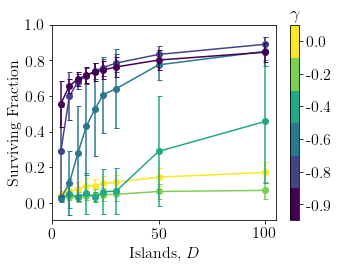

In [1130]:
cutoff = np.exp(-40)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
cvec = g_vec

# norm = mpl.colors.Normalize(vmin=min(cvec)-.1,vmax=max(cvec))
# cmap = mpl.cm.get_cmap('viridis',len(cvec))
# colors = cmap(norm(cvec))
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])

cnum = len(cvec)
cmap = mpl.cm.get_cmap('viridis',cnum)
colors = cmap(np.arange(cnum))
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])
clb = plt.colorbar(sm,ticks = (0.5+np.arange(cnum))/cnum)
clb.ax.set_yticklabels(cvec)
clb.ax.set_title(r'$\gamma$')

num_survive = np.sum(n_mean_array>cutoff,axis=-1)
num_survive_mean = np.mean(num_survive,axis=-1)
num_survive_std = np.std(num_survive,axis=-1)

for g_ind in range(g_num):
    plt.errorbar(D_vec,num_survive_mean[:,g_ind]/K,num_survive_std[:,g_ind]/K,fmt='o-',capsize=2.5,alpha=1,zorder = -g_ind,color=colors[g_ind])
    
plt.ylabel('Surviving Fraction')
plt.xlabel(r'Islands, $D$')
plt.xlim((0,105))
plt.ylim((-.1,1))
# plt.xticks(np.arange(0,60,10))

plt.tight_layout()

plt.savefig('surviving_fraction_vs_islands_colorbar.pdf')

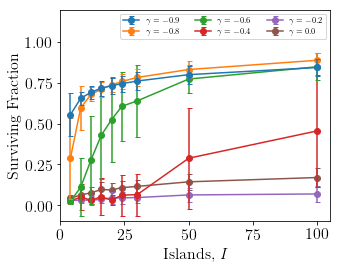

In [1266]:
cutoff = np.exp(-40)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
cvec = g_vec


num_survive = np.sum(n_mean_array>cutoff,axis=-1)
num_survive_mean = np.mean(num_survive,axis=-1)
num_survive_std = np.std(num_survive,axis=-1)

for g_ind in range(g_num):
    plt.errorbar(D_vec,num_survive_mean[:,g_ind]/K,num_survive_std[:,g_ind]/K,fmt='o-',capsize=2.5,alpha=1,zorder = -g_ind,label=r'$\gamma = {}$'.format(g_vec[g_ind]))
    
plt.ylabel('Surviving Fraction')
plt.xlabel(r'Islands, $I$')
plt.xlim((0,105))
plt.ylim((-.1,1.2))
# plt.xticks(np.arange(0,60,10))
plt.legend(prop={'size':8},ncol=3)

plt.tight_layout()

plt.savefig('surviving_fraction_vs_islands.pdf')

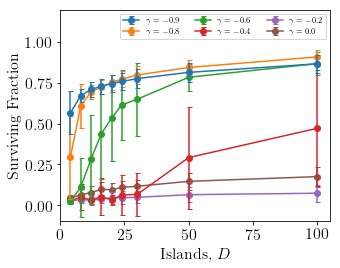

In [1131]:
# No cutoff. Besides the extinction threshold during the simulation

cutoff = 0

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
cvec = g_vec


num_survive = np.sum(n_mean_array>cutoff,axis=-1)
num_survive_mean = np.mean(num_survive,axis=-1)
num_survive_std = np.std(num_survive,axis=-1)

for g_ind in range(g_num):
    plt.errorbar(D_vec,num_survive_mean[:,g_ind]/K,num_survive_std[:,g_ind]/K,fmt='o-',capsize=2.5,alpha=1,zorder = -g_ind,label=r'$\gamma = {}$'.format(g_vec[g_ind]))
    
plt.ylabel('Surviving Fraction')
plt.xlabel(r'Islands, $D$')
plt.xlim((0,105))
plt.ylim((-.1,1.2))
# plt.xticks(np.arange(0,60,10))
plt.legend(prop={'size':8},ncol=3)

plt.tight_layout()

# plt.savefig('surviving_fraction_vs_islands.pdf')

## Phase_space1: Surviving species vs Migration Rate

Plot of fraction of species with migration boundary $\bar{n} \ m > 1$. 
* D = 30, $\gamma = -0.8$, K = 100

In [1267]:
data = np.load('phase_space_m_scaling.npz')
data = data['data'][()]
print(data.keys())

dict_keys(['infD_freq_mean_array', 'finiteD_freq_mean_array', 'finiteD_file_present', 'M_vec', 'D', 'gamma', 'infD_file_present', 'K', 'm_vec'])


In [1268]:
[data['D'], data['gamma'], data['K']]

[30, -0.8, 100]

In [1269]:
data['finiteD_freq_mean_array'].shape

(11, 20, 100)

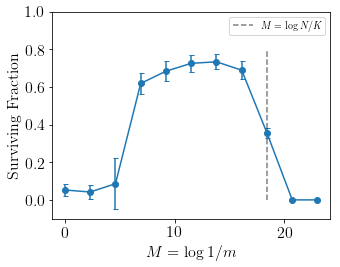

In [45]:
N = 1e10  #freq cutoff = 1/(Nm)


freq_mean = data['finiteD_freq_mean_array']
file_present = data['finiteD_file_present']
m_vec = data['m_vec']
M_vec = data['M_vec']

m_num, rep_num, K = np.shape(freq_mean)



num_surv_mean = np.zeros((m_num))
num_surv_std = np.zeros((m_num))

for m_ind in range(m_num):
    freq_cutoff = 1/(N*m_vec[m_ind])
    num_surv = np.sum(freq_mean[m_ind]>freq_cutoff,axis=1)
    num_surv_mean[m_ind] = np.mean(num_surv[file_present[m_ind,:]==1])
    num_surv_std[m_ind] = np.std(num_surv[file_present[m_ind,:]==1])

    
plt.figure(figsize=(5,4))
plt.errorbar(M_vec,num_surv_mean/K,num_surv_std/K,fmt='o-',capsize=2.5)

vec = np.arange(0,.9,.1)
plt.plot(np.log(N/K)+0*vec,vec,'k--',alpha=0.5,label='$M = \log N/K$')

plt.legend(prop={'size':10})

plt.ylabel('Surviving Fraction')
plt.xlabel(r'$M = \log 1/m$')
# plt.xlim((0,53))
plt.ylim((-.1,1))
# plt.xticks(np.arange(0,60,10))
plt.tight_layout()

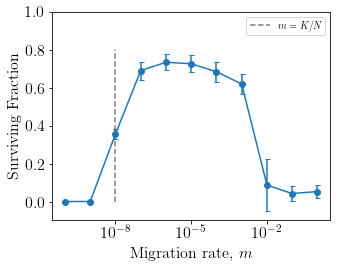

In [120]:
fig, ax = plt.subplots(figsize=(5,4))
ax.errorbar(m_vec,num_surv_mean/K,num_surv_std/K,fmt='o-',capsize=2.5)

vec = np.arange(0,.9,.1)
plt.plot(K/N+0*vec,vec,'k--',alpha=0.5,label='$m = K/N$')

ax.set_ylabel('Surviving Fraction')
ax.set_xlabel(r'Migration rate, $m$')
ax.set_xscale('log')
ax.set_ylim((-.1,1))

plt.legend(prop={'size':10})
# # xlims = ax.get_xlim()
# ax2 = ax.twiny()
# # ax2.set_xticks(ax.get_xlim())
# # ax2.set_xscale('log')
# xlims = np.array(ax.get_xlim())
# print(xlims)
# ax2.set_xlim(np.log(1/xlims))
# # ax2.set_xticks([])

# ax2.set_xlabel(r'$M = \log 1/m$')

# ax2.set_xticklabels(tick_function(ax.get_xticks()))

# ax2.set_xticks(ax.get_xticks())


plt.tight_layout()

# plt.savefig('surviving_frac_vs_migration.pdf')

In [98]:
ax2.get_xticks()

array([1.e-14, 1.e-11, 1.e-08, 1.e-05, 1.e-02, 1.e+01, 1.e+04])

## Old Versions

### Phase_space_inf0: Surviving fraction with migration rate

In [ ]:
data = np.load('phase_space_m_scaling.npz')
data = data['data'][()]
print(data.keys())

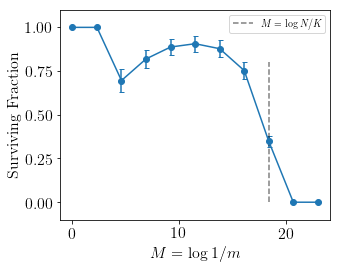

In [477]:
N = 1e10  #freq cutoff = 1/(Nm)


freq_mean = data['infD_freq_mean_array']
file_present = data['infD_file_present']
m_vec = data['m_vec']
M_vec = data['M_vec']

m_num, rep_num, K = np.shape(freq_mean)



num_surv_mean = np.zeros((m_num))
num_surv_std = np.zeros((m_num))

for m_ind in range(m_num):
    freq_cutoff = 1/(N*m_vec[m_ind])
    num_surv = np.sum(freq_mean[m_ind]>freq_cutoff,axis=1)
    num_surv_mean[m_ind] = np.mean(num_surv[file_present[m_ind,:]==1])
    num_surv_std[m_ind] = np.std(num_surv[file_present[m_ind,:]==1])

    
plt.figure(figsize=(5,4))
plt.errorbar(M_vec,num_surv_mean/K,num_surv_std/K,fmt='o-',capsize=2.5)

vec = np.arange(0,.9,.1)
plt.plot(np.log(N/K)+0*vec,vec,'k--',alpha=0.5,label='$M = \log N/K$')

plt.legend(prop={'size':10})

plt.ylabel('Surviving Fraction')
plt.xlabel(r'$M = \log 1/m$')
# plt.xlim((0,53))
plt.ylim((-.1,1.1))
# plt.xticks(np.arange(0,60,10))
plt.tight_layout()

### Surviving species vs migration rate

Data parameters:
* D = 30
* K = 50
* $\gamma = -0.8$
* Extinction threshold: essentially $\log n = -\infty$
* Time = 300K

In [7]:
phi_num = 9
rep_num = 10
exp_num = 6
D = 30
K = 50

n_mean_array = np.zeros((phi_num, rep_num, D,K))
n_mean_run_ave_array = np.zeros((phi_num, rep_num,K))
n_end_array = np.zeros((phi_num,rep_num,K))

phi_list = np.zeros(phi_num)

for phi_ind in range(phi_num):
    for rep_ind in range(rep_num):
        file_name = 'many_islands_2018-02-26/many_islands2_m_transition2_phi{}_rep{}.npz'.format(phi_ind,rep_ind)
        data = np.load(file_name)
        
        n_mean = data['n_mean']
        n_mean_array[phi_ind,rep_ind] = n_mean
        
        n_mean_across = np.mean(n_mean,axis=0)
        
        n_traj = data['n_traj']
        n_end_array[phi_ind,rep_ind] = n_traj[:,-1]
        
        phi_list[phi_ind] = data['phi']
        n_mean = data['n_mean']
        K = data['K']
        D = data['D']
        threshold = data['threshold']
        
m_list = K*np.exp(-phi_list)

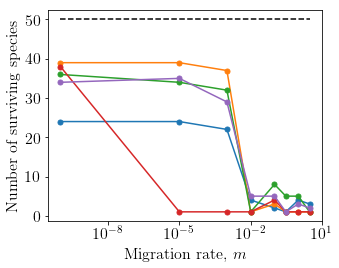

In [18]:
# Plot number of species with abundance>0 at last timepoint.

plt.figure(figsize=(5,4))

n_end_num = np.sum(n_end_array>0,axis=2)

m_inds = [0,1,2,3,5,6,7,8]

for rep_ind in range(rep_num):
    plt.plot(m_list[m_inds],n_end_num[m_inds,rep_ind],'.-',markersize=10,label='Replicate {}'.format(rep_ind))

xvec = m_list[m_inds]
plt.plot(xvec,0*xvec + 50,'k--')  #total number of species
    
plt.xscale('log')
# vec = np.arange(0,27)
# plt.plot(0*vec +1,vec,'--',color='black',zorder=-1,label='$m=1$')
# plt.legend(prop={'size': 8}) 
plt.xlabel(r'Migration rate, $m$')
plt.ylabel(r'Number of surviving species ')
# plt.title(r'Total species = {}'.format(K))

plt.tight_layout()
plt.savefig('figures/presentation_plotting_052018_many_islands_good_reps.pdf')

### Number  of surviving species vs number of islands 1
Data parameters:
* K = 50
* $M \approx 21$
* $\gamma = -0.8$
* Extinction threshold: essentially $\log n = -\infty$
* Time = 300K

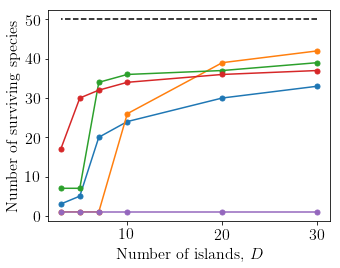

In [19]:
D_num = 6
K_num = 2
rep_num = 5

K_list = np.zeros(K_num)
D_list = np.zeros(D_num)

plt.figure(figsize=(5,4))

for K_ind in [1]:
    for rep_ind in range(rep_num):
        entropy_list = np.zeros(D_num)
        end_num_list = np.zeros(D_num)
        for D_ind in range(D_num):
            file_name = 'many_islands_2018-02-26/many_islands2_D_transition_K{}_D{}_rep{}.npz'.format(K_ind,D_ind,rep_ind)
            data = np.load(file_name)
            K = data['K']
            K_list[K_ind] = K
            D_list[D_ind] = data['D']
            
            n_mean = data['n_mean']
            
            nbar_traj = data['nbar_traj']
            end_num = np.sum(nbar_traj[:,-1]>0)
            end_num_list[D_ind] = end_num
        
        if K_ind==1:
            if rep_ind==0:
                plt.plot(D_list,end_num_list,'.-',color='C{}'.format(rep_ind),markersize=10,label='$K = {}$'.format(K))
            else:
                plt.plot(D_list,end_num_list,'.-',color='C{}'.format(rep_ind),markersize=10)
        else:
            if rep_ind==0:
                plt.plot(D_list,end_num_list,'^--',color='C{}'.format(rep_ind),markersize=6,label='$K = {}$'.format(K))
            else:
                plt.plot(D_list,end_num_list,'^--',color='C{}'.format(rep_ind),markersize=6)

xvec = D_list
plt.plot(xvec,0*xvec + 50,'k--')  #total number of species

plt.xlabel(r'Number of islands, $D$')
plt.ylabel(r'Number of surviving species')
# plt.title(r'Single island diversity, $\log K/m = K/2$')

plt.tight_layout()
# plt.savefig('figures/presentation_plotting_052018_D_transition_K50.pdf')

### Number  of surviving species vs number of islands 2
Data parameters:
* K = 50
* $M = 25$
* $\gamma = -0.8$
* Extinction threshold: essentially $\log n = -\infty$
* Time = 3000K

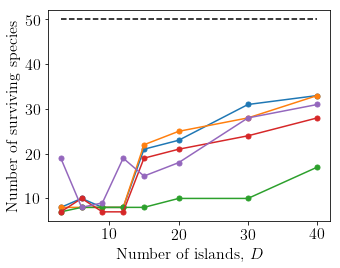

In [158]:
L_ind = 3  #Only consider the infinite population data which has no extinction threshold

D_num = 8
rep_num = 5

plt.figure(figsize=(5,4))

for rep_ind in range(rep_num):
    D_vec = np.zeros((D_num))
    K_surv_vec = np.zeros((D_num))
    for D_ind in range(D_num):
    
        file_name = 'extinction_timescale_2018_08/data/extTime0_D{}_L{}_rep{}_dict.npz'.format(D_ind,L_ind,rep_ind)
        data = np.load(file_name)
        ET = data['ET'][()]

        xbar_traj = ET['xbar_traj']
        K_surv = np.sum(xbar_traj[:,-1]>-500)
        
        D_vec[D_ind] = ET['D']
        K_surv_vec[D_ind] = K_surv
    
    plt.plot(D_vec,K_surv_vec,'.-',markersize=10)

xvec = D_vec
plt.plot(xvec,0*xvec + ET['K'],'k--')  #total number of species

plt.xlabel(r'Number of islands, $D$')
plt.ylabel(r'Number of surviving species')
# plt.title(r'Single island diversity, $\log K/m = K/2$')

plt.tight_layout()

### Dependence on Extinction Threshold

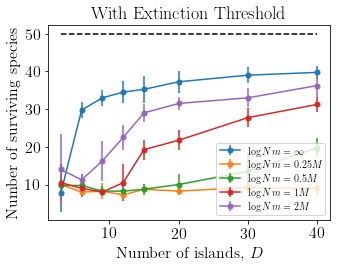

In [391]:
L_num = 5  #Only consider the infinite population data which has no extinction threshold
L_list = ['\infty', .25, .5, 1, 2]

D_num = 8
rep_num = 4  
rep_list = [0,1,3,4]

plt.figure(figsize=(5,4))


for L_ind in range(L_num):
    K_surv_array = np.zeros((D_num,rep_num))
    for ind in range(rep_num):  #Exclude replicate 2 which has low diversity.
        rep_ind = rep_list[ind]
        D_vec = np.zeros((D_num))
        for D_ind in range(D_num):

            file_name = 'extinction_timescale_2018_08/data/extTime0_D{}_L{}_rep{}_dict.npz'.format(D_ind,L_ind,rep_ind)
            data = np.load(file_name)
            ET = data['ET'][()]

            xbar_traj = ET['xbar_traj']
            K_surv = np.sum(xbar_traj[:,-1]>-500)

            D_vec[D_ind] = ET['D']
            K_surv_array[D_ind,ind] = K_surv
            
            L =L_list[L_ind]

    K_surv_vec = np.mean(K_surv_array,axis=1)
    K_surv_err = np.std(K_surv_array,axis=1)
    if L_ind == 0:
        plt.errorbar(D_vec,K_surv_vec,K_surv_err,fmt='.-',markersize=10,label = r'$\log Nm = \infty$'.format(L))
    else:
        plt.errorbar(D_vec,K_surv_vec,K_surv_err,fmt='.-',markersize=10,label = r'$\log Nm = {} M$'.format(L))

xvec = D_vec
plt.plot(xvec,0*xvec + ET['K'],'k--')  #total number of species

plt.xlabel(r'Number of islands, $D$')
plt.ylabel(r'Number of surviving species')
plt.legend(prop = {'size':10})
plt.title(r'With Extinction Threshold')

plt.tight_layout()

plt.savefig('surviving_num_ext_thresh.pdf')

Plot above: Distribution of the island-average abundance $\bar{n}$ over time. The 5 species with the smallest $\bar{n}$ are shown for each epoch. Curves are colored by extinction epoch from early (dark) to late (lighter). This shows that the fluctuations to low abundance are less likely after extinctions have occurred.

# Symmetry Parameter
Data details:
* D = 50
* K = 100
* M = 50
* $\gamma = -0.8$
* Extinction threshold: $\log n = -1.3M$
* Procedure for extinctions:
    * Island-average abundance $\bar{n}$ calculated over a time 50$K$.
    * If no extinctions occured during time period, then lowest $\bar{n}$ removed.
    * If extinctions did occur, then no additional species are removed.
    * Also have data in which species with lowest fluctuation in $\bar{n}$ is removed.

In [311]:
L_num = 2
meth_num = 2
rep_num = 10

epoch_num = 30

surv_num_vec = np.zeros((L_num,meth_num,rep_num,epoch_num))
sym_param_vec = np.zeros((L_num,meth_num,rep_num,epoch_num))
diag_vec = np.zeros((L_num,meth_num,rep_num,epoch_num))
reset_num_array = np.zeros((L_num,meth_num,rep_num,epoch_num))

L_vec = np.zeros((L_num))
meth_vec = [0, 0]


for L_ind,meth_ind,rep_ind in itertools.product(range(L_num),range(meth_num),range(rep_num)):
    file_name = 'extinction_timescale_2018_08/data/extTime2_L{}_meth{}_rep{}_dict.npz'.format(L_ind,meth_ind,rep_ind)
    if os.path.isfile(file_name):
        data = np.load(file_name)
        ET = data['ET'][()]
        
        reset_num_array[L_ind,meth_ind,rep_ind,:] = ET['reset_number_array']
        V1 = ET['V1']
        n_mean_array = np.mean(ET['n_mean_array'],axis=1)
        K1 = ET['K1']
        
        for epoch in range(epoch_num):
            surv_index = n_mean_array[epoch,:] > 0
            surv_num = np.sum(surv_index)
            V_ss = V1[surv_index,:][:,surv_index]
            V_var = np.var(V_ss.flatten())
            K2 = int(surv_num)

            upper_ind = np.triu_indices(K2,1)
            V_mean = np.mean(V_ss[upper_ind])
            V_upper_var = np.var(V_ss[upper_ind])
#             sym_param = np.mean((V_ss[upper_ind]-V_mean) * (V_ss.T[upper_ind]-V_mean))/V_var
            sym_param = np.mean( (V_ss[upper_ind]-V_mean) * (V_ss.T[upper_ind]-V_mean))/V_upper_var
        
            sym_param_vec[L_ind,meth_ind,rep_ind,epoch] = sym_param

            diag = np.diag(V_ss)
            diag_vec[L_ind,meth_ind,rep_ind,epoch] = np.mean(diag**2)/V_var

            surv_num_vec[L_ind,meth_ind,rep_ind,epoch] = surv_num
    else:
        nan_array = np.empty((epoch_num))
        nan_array[:] = np.nan
        surv_num_vec[L_ind,meth_ind,rep_ind,:] = nan_array
        sym_param_vec[L_ind,meth_ind,rep_ind,:] =  nan_array
        diag_vec[L_ind,meth_ind,rep_ind,:] =  nan_array
        reset_num_array[L_ind,meth_ind,rep_ind,:] =  nan_array
    
    L = -(1+ET['thresh']/ET['M'])
    L_vec[L_ind] = L
    meth_vec[meth_ind]= ET['extinction_method']

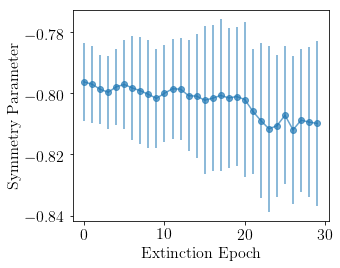

In [315]:
# sym param vs epoch

plt.figure(figsize=(5,4))
for L_ind in [0]:
    for meth_ind in [0]:
        sym_param_plotvec = np.zeros((epoch_num))
        sym_param_std_plotvec = np.zeros((epoch_num))
        epoch_vec = np.arange(epoch_num)
        for epoch in range(epoch_num):
            sym_params = sym_param_vec[L_ind,meth_ind,:,epoch]
            reset0_index = reset_num_array[L_ind,meth_ind,:,epoch]==0
            sym_param_ave = np.mean(sym_params[reset0_index])
            sym_param_plotvec[epoch] = sym_param_ave
            sym_param_std_plotvec[epoch] = np.std(sym_params[reset0_index])
            
        plt.errorbar(epoch_vec,sym_param_plotvec,sym_param_std_plotvec,fmt='o-',alpha=0.67,label='L = {:.1f}M, method = {}'.format(L_vec[L_ind],meth_vec[meth_ind]))
    
plt.ylabel('Symmetry Parameter')
plt.xlabel('Extinction Epoch')
# plt.legend(prop={'size':10})
plt.tight_layout()

Plot above: Change in symmetry parameters after extinctions. Symmetry parameter computed for non-diagonal elements. The points and errorbars are mean and standard deviation, respectively, of ten replicates. 

# Island trajectories

## Extinction

In [86]:
file_name = 'island_traj_data3.npz'
data = np.load(file_name)
IS = data['IslandSim'][()]

n_traj = IS.n_traj
tvec = IS.tvec
nbar_traj = np.mean(n_traj,axis=1)

In [87]:
# dimensions for plotting

figx = 6
figy = 2.5

In [3]:
dir(IS)

['D',
 'Extinction',
 'K',
 'M',
 'N',
 'Normalize',
 'V',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'dt',
 'file_name',
 'gamma',
 'm',
 'n0',
 'n_traj',
 'run_island_sim',
 'sample_end_short',
 'sample_num_short',
 'sample_start_short',
 'sample_time',
 'seed',
 'set_params',
 'start_time_short',
 'thresh',
 'time',
 'total_steps',
 'total_time',
 'tvec',
 'tvec_short',
 'tvec_short_len']

In [4]:
print([IS.D, IS.K, IS.M, IS.gamma, IS.m, IS.thresh])

[10, 75, 20, -0.8, 2.061153622438558e-09, -30]


In [5]:
np.exp(30)

10686474581524.463

/home/atish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/home/atish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


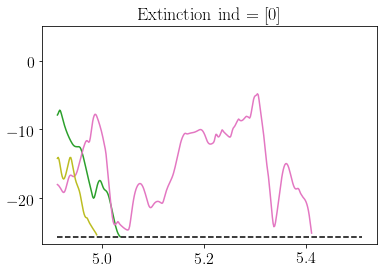

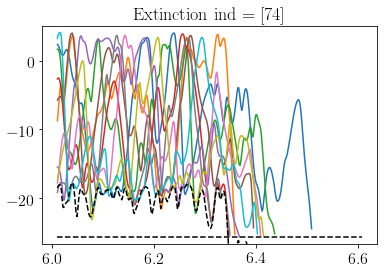

In [88]:
# Find last extinction and plot trajectories of that type
surv_num_vec = np.sum(nbar_traj>0,axis=1)
extinct_time_ind = np.nonzero(surv_num_vec[1:]<surv_num_vec[:-1])[0]
extinct_thresh = IS.thresh +np.log(IS.K)

start_time = 5

for ind in extinct_time_ind:
    
    if ind > int(start_time*IS.K**(3/2)/IS.sample_time):
        plt.figure()
        extinct_time = tvec[ind]

        extinct_type_bool = np.logical_and(nbar_traj[ind,:]>0,nbar_traj[ind+1,:]==0)
        extinct_ind = np.arange(IS.K)[extinct_type_bool]

        window_time = .5
        window_bool = np.logical_and(tvec>extinct_time-window_time,tvec<extinct_time+.1)

        for ii in range(IS.D):
            plt.plot(tvec[window_bool],np.log(n_traj[window_bool,ii,extinct_ind]))
            
        plt.plot(tvec[window_bool],np.log(IS.m*nbar_traj[window_bool,extinct_ind]),'k--')
        plt.plot(tvec[window_bool], extinct_thresh + 0*tvec[window_bool],'k--')
        plt.title('Extinction ind = {}'.format(extinct_ind))
        plt.ylim((extinct_thresh-1,5))

/Users/michaelpearce/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less_equal
/Users/michaelpearce/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in log


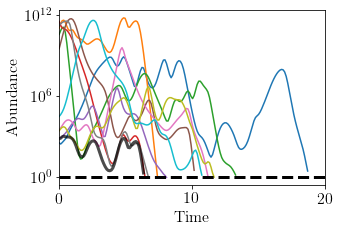

In [13]:
# Find last extinction and plot trajectories of that type
K = IS.K
D = IS.D
M = IS.M
logN = -IS.thresh

N = np.exp(-IS.thresh)
N_rescale = 1e12
log_rescale = np.log(N_rescale)/np.log(N)
M_rescale = M*log_rescale
m = np.exp(-M)
m_rescale = np.exp(-M_rescale)

surv_num_vec = np.sum(nbar_traj>0,axis=1)
extinct_time_ind = np.nonzero(surv_num_vec[1:]<surv_num_vec[:-1])[0]
extinct_thresh = IS.thresh + np.log(IS.K)

start_time = 5

ind_array = extinct_time_ind[extinct_time_ind > int(start_time*IS.K**(3/2)/IS.sample_time)]
    
ind = ind_array[1]


plt.figure(figsize=(5,3.5))
extinct_time = tvec[ind]

extinct_type_bool = np.logical_and(nbar_traj[ind,:]>0,nbar_traj[ind+1,:]==0)
extinct_ind = np.arange(IS.K)[extinct_type_bool]

window_time = .25
window_bool = np.logical_and(tvec>extinct_time-window_time,tvec<extinct_time+.05)
tvec1 = (tvec[window_bool] - tvec[window_bool][0])*K

n_traj[n_traj<=np.exp(extinct_thresh)] = np.nan

for d in range(IS.D):
    plt.plot(tvec1,N_rescale*(n_traj[window_bool,d,extinct_ind]/IS.K)**(log_rescale),alpha=1)

mig_boundary = np.log(IS.m*nbar_traj[window_bool,extinct_ind])
mig_boundary[mig_boundary<extinct_thresh] = np.nan
plt.plot(tvec1,N_rescale*(np.exp(mig_boundary-np.log(IS.K)))**(log_rescale),'k',linewidth=3,alpha=0.7,label=r'$\log m\bar{n}/N$')
plt.plot(tvec1,N_rescale*(np.exp(extinct_thresh + 0*tvec1-np.log(IS.K)))**(log_rescale),'k--',linewidth=3,label = r'$\log 1/N$')

# plt.ylim((extinct_thresh-1-np.log(IS.K),2))
plt.yscale('log')
plt.yticks([1,1e6,1e12])
plt.xlim([0,20])
plt.xticks([0,10,20])
plt.xlabel(r'Time')
plt.ylabel(r'Abundance')
# plt.title('Extinction of one type across {} islands'.format(D))
plt.tight_layout()

file = 'islands_trajectory_extinction_atish2.pdf'.format(D,K,M,logN)
# plt.savefig(file)

/home/atish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log


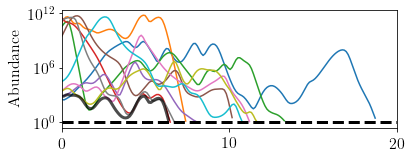

In [89]:
# Find last extinction and plot trajectories of that type
K = IS.K
D = IS.D
M = IS.M
logN = -IS.thresh

N = np.exp(-IS.thresh)
N_rescale = 1e12
log_rescale = np.log(N_rescale)/np.log(N)
M_rescale = M*log_rescale
m = np.exp(-M)
m_rescale = np.exp(-M_rescale)

surv_num_vec = np.sum(nbar_traj>0,axis=1)
extinct_time_ind = np.nonzero(surv_num_vec[1:]<surv_num_vec[:-1])[0]
extinct_thresh = IS.thresh + np.log(IS.K)

start_time = 5

ind_array = extinct_time_ind[extinct_time_ind > int(start_time*IS.K**(3/2)/IS.sample_time)]
    
ind = ind_array[1]


plt.figure(figsize=(figx,figy))
extinct_time = tvec[ind]

extinct_type_bool = np.logical_and(nbar_traj[ind,:]>0,nbar_traj[ind+1,:]==0)
extinct_ind = np.arange(IS.K)[extinct_type_bool]

window_time = .25
window_bool = np.logical_and(tvec>extinct_time-window_time,tvec<extinct_time+.05)
tvec1 = (tvec[window_bool] - tvec[window_bool][0])*K

n_traj[n_traj<=np.exp(extinct_thresh)] = np.nan

for d in range(IS.D):
    plt.plot(tvec1,N_rescale*(n_traj[window_bool,d,extinct_ind]/IS.K)**(log_rescale),alpha=1)

mig_boundary = np.log(IS.m*nbar_traj[window_bool,extinct_ind])
mig_boundary[mig_boundary<extinct_thresh] = np.nan
plt.plot(tvec1,N_rescale*(np.exp(mig_boundary-np.log(IS.K)))**(log_rescale),'k',linewidth=3,alpha=0.7,label=r'$\log m\bar{n}/N$')
plt.plot(tvec1,N_rescale*(np.exp(extinct_thresh + 0*tvec1-np.log(IS.K)))**(log_rescale),'k--',linewidth=3,label = r'$\log 1/N$')

# plt.ylim((extinct_thresh-1-np.log(IS.K),2))
plt.yscale('log')
plt.yticks([1,1e6,1e12])
plt.xlim([0,20])
plt.xticks([0,10,20])
#plt.xlabel(r'Time')
plt.ylabel(r'Abundance')
# plt.title('Extinction of one type across {} islands'.format(D))
plt.tight_layout()

file = 'figures/islands_trajectory_extinction_new.pdf'.format(D,K,M,logN)
plt.savefig(file)

In [345]:
m

2.061153622438558e-09

In [346]:
np.exp()

20

## Stable Plot

In [90]:
file_name = 'island_traj_data3.npz'
data = np.load(file_name)
IS = data['IslandSim'][()]

n_traj = IS.n_traj
tvec = IS.tvec
nbar_traj = np.mean(n_traj,axis=1)

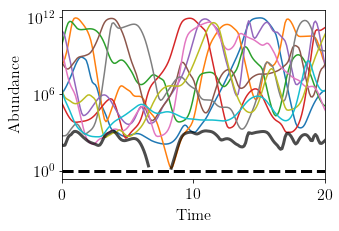

In [91]:
# Find last extinction and plot trajectories of that type
K = IS.K
D = IS.D
M = IS.M
logN = -IS.thresh

N = np.exp(-IS.thresh)
N_rescale = 1e12
log_rescale = np.log(N_rescale)/np.log(N)
M_rescale = M*log_rescale

surv_index = np.arange(K)[nbar_traj[-1,:]>0]
extinct_thresh = IS.thresh +np.log(IS.K)

ind = 1

plt.figure(figsize=(5,3.5))

type_ind = surv_index[ind]

window_time = 0.3
window_bool = tvec>tvec[-1]-window_time
tvec1 = (tvec[window_bool])*K
tvec1 = tvec1-tvec1[0]

n_traj[n_traj<np.exp(extinct_thresh)] = np.nan

for d in range(IS.D):
    plt.plot(tvec1,N_rescale*(n_traj[window_bool,d,type_ind]/IS.K)**(log_rescale),alpha=1)

mig_boundary = np.log(IS.m*nbar_traj[window_bool,type_ind])
mig_boundary[mig_boundary<extinct_thresh] = np.nan
plt.plot(tvec1,N_rescale*(np.exp(mig_boundary-np.log(IS.K)))**(log_rescale),'k-',linewidth=3,alpha=0.7,label=r'$\log m\bar{n}/N$')
plt.plot(tvec1,N_rescale*(np.exp(extinct_thresh + 0*tvec1-np.log(IS.K)))**(log_rescale),'k--',linewidth=3,label = r'$\log 1/N$')
# plt.title('Extinction ind = {}'.format(extinct_ind))
# plt.ylim((extinct_thresh-1-np.log(IS.K),2))
plt.yscale('log')
plt.yticks([1,1e6,1e12])
plt.xlim([0,20])
plt.xticks([0,10,20])
plt.xlabel(r'Time')
plt.ylabel(r'Abundance')
# plt.title('One type across {} islands'.format(D))
plt.tight_layout()

file = 'islands_trajectory_stable_atish2.pdf'.format(D,K,M,logN)
# plt.savefig(file)

/home/atish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less


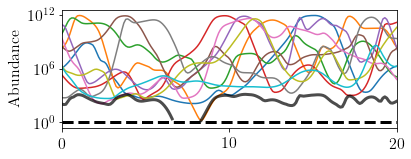

In [92]:
# Find last extinction and plot trajectories of that type
K = IS.K
D = IS.D
M = IS.M
logN = -IS.thresh

N = np.exp(-IS.thresh)
N_rescale = 1e12
log_rescale = np.log(N_rescale)/np.log(N)
M_rescale = M*log_rescale

surv_index = np.arange(K)[nbar_traj[-1,:]>0]
extinct_thresh = IS.thresh +np.log(IS.K)

ind = 1

plt.figure(figsize=(figx,figy))

type_ind = surv_index[ind]

window_time = 0.3
window_bool = tvec>tvec[-1]-window_time
tvec1 = (tvec[window_bool])*K
tvec1 = tvec1-tvec1[0]

n_traj[n_traj<np.exp(extinct_thresh)] = np.nan

for d in range(IS.D):
    plt.plot(tvec1,N_rescale*(n_traj[window_bool,d,type_ind]/IS.K)**(log_rescale),alpha=1)

mig_boundary = np.log(IS.m*nbar_traj[window_bool,type_ind])
mig_boundary[mig_boundary<extinct_thresh] = np.nan
plt.plot(tvec1,N_rescale*(np.exp(mig_boundary-np.log(IS.K)))**(log_rescale),'k-',linewidth=3,alpha=0.7,label=r'$\log m\bar{n}/N$')
plt.plot(tvec1,N_rescale*(np.exp(extinct_thresh + 0*tvec1-np.log(IS.K)))**(log_rescale),'k--',linewidth=3,label = r'$\log 1/N$')
# plt.title('Extinction ind = {}'.format(extinct_ind))
# plt.ylim((extinct_thresh-1-np.log(IS.K),2))
plt.yscale('log')
plt.yticks([1,1e6,1e12])
plt.xlim([0,20])
plt.xticks([0,10,20])
#plt.xlabel(r'Time')
plt.ylabel(r'Abundance')
# plt.title('One type across {} islands'.format(D))
plt.tight_layout()

file = 'figures/islands_trajectory_stable_new.pdf'.format(D,K,M,logN)
plt.savefig(file)

## Invasion of new type

Did some editing of this code to get it to work. Seemed like there were issues due to the runtime of the first
(and second) runs, to establish a type with good invadability and then to invade it properly. Seems that
too many things went extinct by the timepoint selected, which then leads to no other type able to invade.
Would be good to check these changes and make sure things are ok.

-Atish

In [247]:
file_name = 'island_traj_data2.npz'
data = np.load(file_name)
IS = data['IslandSim'][()]
K = IS.K
D = IS.D

n_traj = IS.n_traj
tvec = IS.tvec
nbar_traj = np.mean(n_traj,axis=1)

/home/atish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log


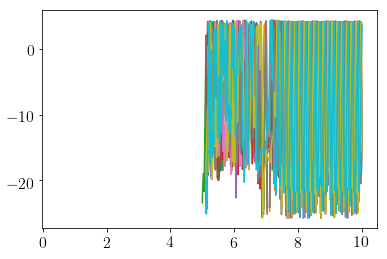

In [287]:
# choose species based on mean abundance
nbar_traj = np.mean(IS.n_traj,axis=1)
surv_species = np.nonzero(nbar_traj[-1,:]>0)[0]
n_mean = np.mean(nbar_traj[:,surv_species],axis=0)
sort_ind = np.argsort(n_mean)
remove_ind = surv_species[sort_ind[1]]  #choose surviving species with smallest mean


t0 = 80
n_traj = IS.n_traj
tvec = IS.tvec

#t_ind = np.argmin((tvec-t0)**2)
# sample early timepoint
t_ind = 100
n0 = n_traj[t_ind,:,:]
n0[:,remove_ind] = np.zeros((D))

#break

file_name = 'test_remove'
time0 = 5
IslandSim = fpm.IslandSimWithExtinction(file_name,IS.D,IS.K,IS.M,IS.gamma,IS.thresh,time0,IS.dt,IS.sample_time,IS.seed,n0 = n0,V = IS.V)

n_traj = IslandSim.n_traj
tvec = IslandSim.tvec

#n0 = n_traj[-1,:,:]
# invade at earlier timepoint
n0 = n_traj[300,:,:]
single_island_init = np.zeros((D))
fitness = np.einsum('ij,dj->di',IS.V,n0)
d_ind = np.argmax(fitness[:,remove_ind])
single_island_init[d_ind] = 10*np.exp(IS.thresh)*K

n0[:,remove_ind] = single_island_init

file_name = 'test_remove'
time1 = 5
IslandSim = fpm.IslandSimWithExtinction(file_name,IS.D,IS.K,IS.M,IS.gamma,IS.thresh,time1,IS.dt,IS.sample_time,IS.seed,n0 = n0,V = IS.V)

n_traj = np.concatenate((n_traj,IslandSim.n_traj))
tvec = np.concatenate((tvec,IslandSim.tvec+time0))

for d in range(D):
    plt.plot(tvec,np.log(n_traj[:,d,remove_ind]))



/home/atish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


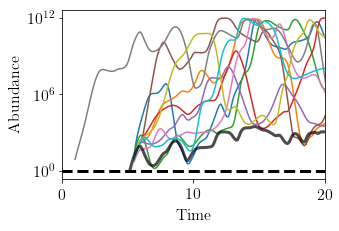

In [273]:
M = IslandSim.M
K = IslandSim.K
D = IslandSim.D
extinct_thresh = IslandSim.thresh+np.log(K)

N = np.exp(-IslandSim.thresh)
N_rescale = 1e12
log_rescale = np.log(N_rescale)/np.log(N)
M_rescale = M*log_rescale

tvec1 = (tvec-time0)*K+1
# tvec1 = tvec1-tvec1[0]

plt.figure(figsize=(5,3.5))

nbar = np.mean(n_traj[:,:,remove_ind],axis=1)

n_traj_plot = 1.*n_traj
n_traj_plot[n_traj<np.exp(extinct_thresh)] = np.nan

for d in range(D):
    plt.plot(tvec1,N_rescale*(n_traj_plot[:,d,remove_ind]/IS.K)**(log_rescale))


migration_boundary = np.log(nbar) - M
thresh = IslandSim.thresh + np.log(IslandSim.K)
migration_boundary[migration_boundary<extinct_thresh] = np.nan
plt.plot(tvec1,N_rescale*(np.exp(migration_boundary-np.log(IS.K)))**(log_rescale),'k',linewidth=3,alpha=0.7,label=r'$\log m\bar{n}/N$')
plt.plot(tvec1,N_rescale*(np.exp(extinct_thresh + 0*tvec1-np.log(IS.K)))**(log_rescale),'k--',linewidth=3,label = r'$\log 1/N$')

plt.yscale('log')
plt.yticks([1,1e6,1e12])
# plt.legend(prop={'size':12})
# plt.xlim((-0.0*M,1.1*M))
plt.xlim((0,20))
plt.xticks([0,10,20])
plt.xlabel(r'Time')
plt.ylabel(r'Abundance')
# plt.title('Invasion from one island')
plt.tight_layout()

file = 'islands_trajectory_invasion_atish2.pdf'.format(D,K,M,logN)
plt.savefig(file)

/home/atish/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


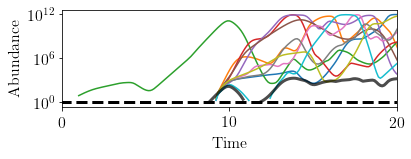

In [289]:
M = IslandSim.M
K = IslandSim.K
D = IslandSim.D
extinct_thresh = IslandSim.thresh+np.log(K)

N = np.exp(-IslandSim.thresh)
N_rescale = 1e12
log_rescale = np.log(N_rescale)/np.log(N)
M_rescale = M*log_rescale

tvec1 = (tvec-time0)*K+1
# tvec1 = tvec1-tvec1[0]

plt.figure(figsize=(figx,figy))

nbar = np.mean(n_traj[:,:,remove_ind],axis=1)

n_traj_plot = 1.*n_traj
n_traj_plot[n_traj<np.exp(extinct_thresh)] = np.nan

for d in range(D):
    plt.plot(tvec1,N_rescale*(n_traj_plot[:,d,remove_ind]/IS.K)**(log_rescale))


migration_boundary = np.log(nbar) - M
thresh = IslandSim.thresh + np.log(IslandSim.K)
migration_boundary[migration_boundary<extinct_thresh] = np.nan
plt.plot(tvec1,N_rescale*(np.exp(migration_boundary-np.log(IS.K)))**(log_rescale),'k',linewidth=3,alpha=0.7,label=r'$\log m\bar{n}/N$')
plt.plot(tvec1,N_rescale*(np.exp(extinct_thresh + 0*tvec1-np.log(IS.K)))**(log_rescale),'k--',linewidth=3,label = r'$\log 1/N$')

plt.yscale('log')
plt.yticks([1,1e6,1e12])
# plt.legend(prop={'size':12})
# plt.xlim((-0.0*M,1.1*M))
plt.xlim((0,20))
plt.xticks([0,10,20])
plt.xlabel(r'Time')
plt.ylabel(r'Abundance')
# plt.title('Invasion from one island')
plt.tight_layout()

file = 'figures/islands_trajectory_invasion_new.pdf'.format(D,K,M,logN)
plt.savefig(file)

# Island Trajectories for DSF

In [206]:
file_name = 'trajectories_largeK_DSF'
D = 25
K = 150
M = 10
gamma = -0.9
thresh = -4*M
time = 20*(M/K)
dt = 0.1*np.sqrt(K/M)
sample_time = 1*dt
seed = 2

fpm.IslandSimWithExtinction(file_name,D,K,M,gamma,thresh,time,dt,sample_time,seed,n0 = None, V = None,K0 = None)

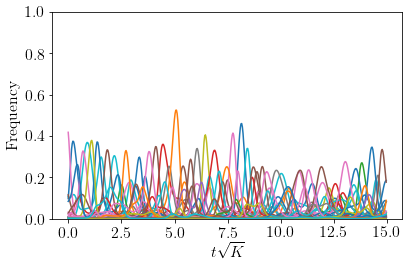

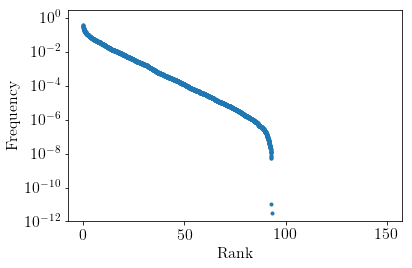

In [221]:
file_name = 'trajectories_largeK_DSF'
data = np.load(file_name+'.npz')
data = data['IslandSim'].item()

K = data['K']
logN = -data['thresh']
N = np.exp(logN)
M = data['M']
D = data['D']
n_traj = data['n_traj']/K
tvec = data['tvec_short']/np.sqrt(K)

t0 = 18*M
t1 = 19.5*M

ind0 = np.argmin((tvec-t0)**2)
ind1 = np.argmin((tvec-t1)**2)

for ii in range(K):
    plt.plot(tvec[ind0:ind1]-t0,n_traj[ind0:ind1,0,ii])
    
# plt.yscale('log')
plt.ylim([1e-10,1])
# plt.xlim(())

plt.xlabel(r'$t\sqrt{K}$')
plt.ylabel(r'Frequency')
plt.tight_layout()
plt.savefig('trajectories_largeK_linear_DSF.pdf')

plt.figure()

n = n_traj[-1].flatten()
n_sorted = np.sort(n)
rank = np.arange(len(n))[::-1]/D

plt.plot(rank,n_sorted,'.')

plt.ylim([1e-12,3])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.yscale('log')
plt.tight_layout()
# plt.savefig('rank_freq_largeK_DSF.pdf')

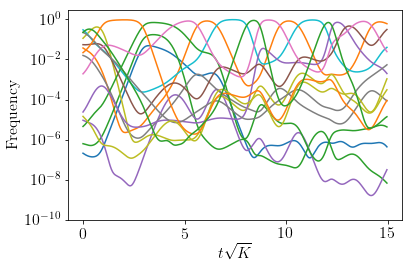

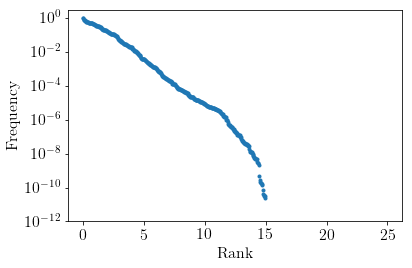

In [218]:
file_name = 'trajectories_smallK_DSF'
data = np.load(file_name+'.npz')
data = data['IslandSim'].item()

K = data['K']
logN = -data['thresh']
N = np.exp(logN)
M = data['M']
D = data['D']
n_traj = data['n_traj']/K
tvec = data['tvec_short']/np.sqrt(K)

t0 = 5*M
t1 = 6.5*M

ind0 = np.argmin((tvec-t0)**2)
ind1 = np.argmin((tvec-t1)**2)

for ii in range(K):
    plt.plot(tvec[ind0:ind1]-t0,n_traj[ind0:ind1,0,ii])
    
plt.yscale('log')
plt.ylim([1e-10,3])
# plt.xlim(())

plt.xlabel(r'$t\sqrt{K}$')
plt.ylabel(r'Frequency')
plt.tight_layout()
# plt.savefig('trajectories_smallK_DSF.pdf')

plt.figure()

n = n_traj[ind1].flatten()
n_sorted = np.sort(n)
rank = np.arange(len(n))[::-1]/D

plt.plot(rank,n_sorted,'.')
plt.ylim([1e-12,3])
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.yscale('log')

plt.tight_layout()
plt.savefig('rank_freq_smallK_DSF.pdf')

In [133]:
time*K**(3/2)

447.21359549995793

In [135]:
10*M*np.sqrt(K)

447.21359549995793